# **Multiple Models ML + ResNet Threshold Synthetic Cross Validation**


## *1. Dataset Loading and Preprocessing*

### **1.1. Importing Required Libraries**

- Pathlib, os, shutil: These are used for handling file paths and directory manipulations. shutil is helpful in copying or moving files.
- NumPy: Essential for handling large arrays and numerical operations.
- Matplotlib, Seaborn: For data visualization. matplotlib.pyplot helps create various plots, and seaborn offers more advanced visualizations, typically with a higher-level API.
- Pandas: For data manipulation, especially working with tabular data. pandas.DataFrame is extensively used for loading, modifying, and analyzing datasets.
- Pickle: For serializing Python objects, commonly used to save/load objects such as models and dataframes.
- PIL (Python Imaging Library): For handling image data, including reading, processing, and transforming images.
- TQDM: For displaying progress bars when running loops, typically useful for large datasets or long-running operations.
- PyTorch & torchvision: Essential libraries for building and training deep learning models. torch.utils.data.DataLoader is for batching and loading datasets, torchvision.datasets provides utilities for image datasets, and torch.optim contains optimization algorithms.
- scikit-learn: Specifically, StandardScaler for feature scaling, and BaseEstimator for defining custom models.

These libraries will help in the preprocessing, model training, evaluation, and visualization steps throughout the project.

#### Key Notes:

 - Using pathlib for path handling improves cross-platform compatibility.

- Torch and Torchvision are used to load image datasets and prepare for deep learning tasks.

- Using Pickle enables storing large DataFrames efficiently for future use.

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

import pickle

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

c:\Users\majid\anaconda3\envs\ENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### **1.2. Download and extract the data**

#### **Dataset Directory and Checkpoints Setup**

- Setting up dataset paths dynamically using os.path.abspath("__file__") to locate the dataset.

- Normalizing paths for compatibility across Windows and Linux.

- Checkpoint directory creation ensures data persistence for large datasets.

#### Procedure

1. **Define the Dataset Directory**:
   - The `dataset_dir` variable is constructed using `os.path.join()` to specify the path where the dataset is stored. The dataset directory is located relative to the current working directory, and we use `os.path.normpath()` to ensure the path format is correct for the system.

2. **Specify the File Path**:
   - The variable `file_path` is used to specify the full path to the `mvtec_meta_features_dataset.csv` file within the dataset directory.

3. **Avoiding MemoryError**:
   - The file is expected to be loaded in chunks, which is important for managing large datasets that might not fit entirely into memory at once. This chunking approach will help avoid potential `MemoryError` issues when processing large files.


#### Key Notes:

- Using os.makedirs(..., exist_ok=True) prevents errors if the directory already exists.

- Relative path handling makes the script more portable across environments.

- Checkpoints help reduce load time by storing preprocessed data.

### **1.3. Dataset Directory and Checkpoints Setup**

- Setting up dataset paths dynamically using os.path.abspath("__file__") to locate the dataset.

- Normalizing paths for compatibility across Windows and Linux.

- Checkpoint directory creation ensures data persistence for large datasets.

- The dataset is stored in `mvtec_meta_features_dataset.csv`.
- The script dynamically locates the dataset folder relative to the script’s location.
- `os.path.normpath()` ensures cross-platform compatibility.


#### Key Notes:

- Using os.makedirs(..., exist_ok=True) prevents errors if the directory already exists.

- Relative path handling makes the script more portable across environments.

- Checkpoints help reduce load time by storing preprocessed data.

In [3]:
# Load the dataset in chunks to avoid MemoryError
dataset_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "..\..\..\Dataset")
dataset_dir = os.path.normpath(dataset_dir)
file_path = os.path.join(dataset_dir, 'mvtec_meta_features_dataset.csv')


### **1.4. Loading Dataset with Chunk Processing**

#### Explanation:

- Checks if a preprocessed dataset exists to load faster.

- Uses chunk processing (chunksize=1000) to prevent MemoryErrors on large CSV files.

- Saves the final DataFrame to a pickle file for efficiency.

- **Checkpoints** store intermediate results to avoid redundant computations.
- The script ensures the checkpoint directory exists (`os.makedirs(exist_ok=True)`).
- The checkpoint file (`features_df_checkpoint.pkl`) is used to store the dataset after initial processing.

#### Key Notes:

- Chunk processing is essential for handling large datasets in memory-constrained environments.

- Pickle is faster than CSV for loading structured data.

- Using ignore_index=True ensures the DataFrame is properly indexed after concatenation.


### **1.5. Display Dataset Preview**

This prints a preview of the dataset to ensure it loaded correctly.

- **Avoids Memory Errors** by loading data in chunks (`chunksize=1000`).
- **Improves Performance**: If a checkpoint exists, the dataset is loaded from it instead of being reprocessed.
- **Pandas `concat()`**: Efficiently merges chunks into a single DataFrame.
- **Pickle**: Serializes the DataFrame for fast future access.


#### Exploring the Dataset
- Displays the first few rows of `features_df` to verify loading was successful.
- The dataset contains **features and categories** essential for further processing.

In [4]:
# Define the checkpoint path
checkpoint_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), 'Checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'features_df_checkpoint.pkl')

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
	# Load the DataFrame from the checkpoint file
	with open(checkpoint_path, 'rb') as f:
		features_df = pickle.load(f)
else:
	# Load the dataset in chunks to avoid MemoryError
	chunk_size = 1000 # Adjust the chunk size based on your memory capacity
	chunks = []
	for chunk in pd.read_csv(file_path, chunksize=chunk_size):
		chunks.append(chunk)
	features_df = pd.concat(chunks, ignore_index=True)

	# Save the DataFrame to a checkpoint file
	with open(checkpoint_path, 'wb') as f:
		pickle.dump(features_df, f)

# Display the first few rows of the DataFrame
features_df.head()



,category,subclass,set_type,anomaly_status,anomaly_type,width,height,aspect_ratio,num_pixels_b,num_pixels_g,...,pixel_150519,pixel_150520,pixel_150521,pixel_150522,pixel_150523,pixel_150524,pixel_150525,pixel_150526,pixel_150527,pixel_150528
0,bottle,Consumer Products,train,normal,none,900,900,1.0,6999311,6773371,...,255,255,255,255,255,255,255,255,255,255
1,bottle,Consumer Products,train,normal,none,900,900,1.0,7067411,6860049,...,255,255,255,255,255,255,255,255,255,255
2,bottle,Consumer Products,train,normal,none,900,900,1.0,6960857,6767973,...,255,255,255,255,255,255,255,255,255,255
3,bottle,Consumer Products,train,normal,none,900,900,1.0,6941894,6749162,...,255,255,255,255,255,255,255,255,255,255
4,bottle,Consumer Products,train,normal,none,900,900,1.0,7080991,6879424,...,255,255,255,255,255,255,255,255,255,255


- Dataset Example: The table shows meta-data for a few images. Each row represents an image, and columns represent various image features like:

- Category: The object category the image belongs to.
- Anomaly Status: Whether the image is normal or contains an anomaly.
- Pixel Data: Columns like num_pixels_b, num_pixels_g, and num_pixels_r represent the pixel counts of each color channel. These features can be used for distinguishing different object types or identifying anomalies.

### **1.6. Extracting Unique Categories**
- Extracts **unique values** from the `category` column.
- The dataset categories are sorted alphabetically using `np.sort()`.
- Defines a processing range (`min_categories = 0`, `max_categories = 15`).

In [5]:
# create a list of the categories
categories = np.sort(features_df['category'].unique())
min_categories = 0
max_categories = 15


### **1.7. Loading Image Paths**
- Retrieves paths for **training, testing, validation, and ground truth images**.
- Uses `os.walk()` to recursively scan directories.
- Filters files based on common image extensions (`.png, .jpg, .jpeg, .bmp, .gif`).

### **1.8. Organizing Image Paths**
- Stores paths in dictionaries for quick retrieval.
- This structure enables efficient data loading for **training, validation, and testing**.

In [6]:
# Function to get all image and ground_truth paths for all categories
def load_image_paths_from_category(category):
    train_path = os.path.join(dataset_dir, category, 'train')
    test_path = os.path.join(dataset_dir, category, 'test')
    validation_path = os.path.join(dataset_dir, category, 'validation')
    gt_path = os.path.join(dataset_dir, category, 'ground_truth')
    
    def get_image_paths(root_path):
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        image_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(image_extensions):
                    image_paths.append(os.path.join(dirpath, filename))
        return image_paths
    
    def get_ground_truth_paths(root_path):
        ground_truth_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
        ground_truth_paths = []
        for dirpath, _, filenames in os.walk(root_path):
            for filename in filenames:
                if filename.lower().endswith(ground_truth_extensions):
                    ground_truth_paths.append(os.path.join(dirpath, filename))
        return ground_truth_paths
    
    # Get image and ground_truth paths
    train_image_paths = get_image_paths(train_path)
    test_image_paths = get_image_paths(test_path)
    validation_image_paths_dict = get_image_paths(validation_path)
    gt_image_paths = get_ground_truth_paths(gt_path)
   
    return train_image_paths, test_image_paths, validation_image_paths_dict, gt_image_paths

# Initialize dictionaries to store images
train_image_paths_dict = {}
test_image_paths_dict = {}
validation_image_paths_dict = {}
gt_image_paths_dict = {}

for category in categories:
    train_image_paths, test_image_paths, validation_path, gt_image_paths = load_image_paths_from_category(category)
    train_image_paths_dict[category] = train_image_paths
    test_image_paths_dict[category] = test_image_paths
    validation_image_paths_dict[category] = validation_path
    gt_image_paths_dict[category] = gt_image_paths


## *2. Load a Pretrained Resnet Model*

### **2.1. ResNet50 Feature Extractor**
- Loads a **pre-trained ResNet50 model**.
- **Removes the final classification layer** to use it for feature extraction.
- Moves model to **CUDA (GPU)** for faster inference.
- **Freezes model parameters** to avoid unnecessary gradient computations.
- Deletes the original `resnet_model` to free up memory.

In [7]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).cuda()
model.eval()

for param in model.parameters():
    param.requires_grad = False

del resnet_model

### **2.2. Prepare data transformations**

#### Image Transformations
- Uses the **default preprocessing transformations** provided for ResNet50.
- Ensures that input images are **resized, normalized, and tensor-converted** correctly.

In [8]:
transform = ResNet50_Weights.DEFAULT.transforms()

### *2.3. Creating a Memory Bank for Training, Testing, and Validation Data*
- The **memory bank** stores ResNet-50 feature representations for:
  - Training images (`train_resnet_features_dict`)
  - Testing images (`test_resnet_features_dict`)
  - Validation images (`validation_resnet_features_dict`)
- These feature maps are later used for anomaly detection and classification.
- The model is loaded onto the appropriate **device (GPU or CPU)** based on availability.
- **Pickle Checkpoints** are used to avoid redundant computation.

### Explanation:
- **ResNet-50** extracts feature representations from images.
- The extracted features are **stored as tensors** in a dictionary categorized by image type.
- If a checkpoint exists, it loads previously stored features instead of recalculating them.
- **Tensors are moved to the GPU (CUDA)** for efficient processing.

In [10]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_train_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        train_resnet_features_dict = pickle.load(f)
else:
    train_resnet_features_dict = {}
    

    for category, paths in train_image_paths_dict.items():
        train_features = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).cuda().unsqueeze(0)
                features = model(data)
                train_features.append(features.squeeze().cpu().detach())
        train_resnet_features_dict[category] = torch.stack(train_features).cuda()
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(train_resnet_features_dict, f)


### **2.4 Checkpoint for Test Features**

#### Define the checkpoint file path for storing test features and labels.
- Check if the checkpoint file exists:
  - If it exists, load `test_resnet_features_dict` and `y_true_test_dict` using `pickle.load()`.
  - If not, initialize empty dictionaries for both.
#### Move the model to GPU if available.
#### Iterate through `test_image_paths_dict` to extract test features:
  - Create empty lists for `test_features` and `y_true_test`.
  - Loop through image paths using `tqdm` for progress tracking.
  - Apply transformations and move data to CUDA.
  - Pass data through the model without gradient computation.
  - Store extracted features in `test_features`.
  - Assign labels based on directory names:
    - If 'good' is in the path, label as `0` (Normal).
    - Otherwise, label as `1` (Anomalous).
  - Stack and store extracted features in `test_resnet_features_dict`.
  - Store labels in `y_true_test_dict`.
#### Save `test_resnet_features_dict` and `y_true_test_dict` to the checkpoint file using `pickle.dump()`. 


In [13]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_test_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        test_resnet_features_dict, y_true_test_dict = pickle.load(f)
else:
    test_resnet_features_dict = {}
    y_true_test_dict = {}
    
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for category, paths in test_image_paths_dict.items():
        test_features = []
        y_true_test = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).to(device).unsqueeze(0)
                features = model(data)
                test_features.append(features.squeeze().cpu().detach())
                
                # Determine the label based on the directory name
                if 'good' in pth:
                    y_true_test.append(0)  # Normal
                else:
                    y_true_test.append(1)  # Anomalous
        
        test_resnet_features_dict[category] = torch.stack(test_features).cuda()
        y_true_test_dict[category] = y_true_test
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump((test_resnet_features_dict, y_true_test_dict), f)

### **2.5. Checkpoint for Validation Features**

- Define the checkpoint file path for storing validation features and labels.
- Check if the checkpoint file exists:
  - If it exists, load `validation_resnet_features_dict` and `y_true_validation_dict` using `pickle.load()`.
  - If not, initialize empty dictionaries for both.
- Move the model to CPU.
- Iterate through `validation_image_paths_dict` to extract validation features:
  - Create empty lists for `validation_features` and `y_true_validation`.
  - Loop through image paths using `tqdm` for progress tracking.
  - Apply transformations and move data to CPU.
  - Pass data through the model without gradient computation.
  - Store extracted features in `validation_features`.
  - Assign labels based on directory names:
    - If 'good' is in the path, label as `0` (Normal).
    - Otherwise, label as `1` (Anomalous).
  - Stack and store extracted features in `validation_resnet_features_dict`.
  - Store labels in `y_true_validation_dict`.
- Save `validation_resnet_features_dict` and `y_true_validation_dict` to the checkpoint file using `pickle.dump()`. 


In [15]:
checkpoint_file = os.path.join(checkpoint_dir, 'memory_bank_validation_checkpoint.pkl')

if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        validation_resnet_features_dict, y_true_validation_dict= pickle.load(f)
else:
    validation_resnet_features_dict = {}
    y_true_validation_dict = {}
    
    # Move the model to CPU
    device = torch.device("cpu")
    model = model.to(device)

    for category, paths in validation_image_paths_dict.items():
        validation_features = []
        y_true_validation = []
        for pth in tqdm(paths, leave=False):
            with torch.no_grad():
                data = transform(Image.open(pth).convert('RGB')).to(device).unsqueeze(0)
                features = model(data)
                validation_features.append(features.squeeze().cpu().detach())
                
                # Determine the label based on the directory name
                if 'good' in pth:
                    y_true_validation.append(0)  # Normal
                else:
                    y_true_validation.append(1)  # Anomalous
        
        validation_resnet_features_dict[category] = torch.stack(validation_features)
        y_true_validation_dict[category] = y_true_validation
    
    with open(checkpoint_file, 'wb') as f:
        pickle.dump((validation_resnet_features_dict, y_true_validation_dict), f)

### **2.6. Standardize the dataset**


- **Standardization (zero mean, unit variance)** is applied to make the data comparable across features.
- This prevents certain features from dominating PCA due to different scales.
- **Training data is used to fit the scaler, and the same scaler transforms test and validation data** to maintain consistency.

In [16]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Initialize dictionaries to store normalized dataframes
normalized_train_dfs = {}
normalized_test_dfs = {}
normalized_validation_dfs = {}

# Iterate over each category
for category in categories:
    # Get the train and test dataframes for the current category
    train_df = train_resnet_features_dict[category].cpu().numpy()
    test_df = test_resnet_features_dict[category].cpu().numpy()
    validation_df = validation_resnet_features_dict[category].cpu().numpy()
    
    # Fit the scaler on the train data and transform both train and test data
    normalized_train_dfs[category] = pd.DataFrame(scaler.fit_transform(train_df), columns=[f'feature_{i}' for i in range(train_df.shape[1])])
    normalized_test_dfs[category] = pd.DataFrame(scaler.transform(test_df), columns=[f'feature_{i}' for i in range(test_df.shape[1])])
    normalized_validation_dfs[category] = pd.DataFrame(scaler.transform(validation_df), columns=[f'feature_{i}' for i in range(validation_df.shape[1])])

## *3. Principal Component Analysis (PCA)*
- **Dimensionality reduction technique** that transforms features into a lower-dimensional space.
- **Retains 95% variance** of the data while removing redundant information.
- This helps in:
  - **Reducing memory usage**
  - **Speeding up training**
  - **Avoiding overfitting**
- PCA transformation is **applied separately for each category**.

In [18]:
from sklearn.decomposition import PCA

# Define the checkpoint files for PCA results
pca_checkpoint_path = os.path.join(checkpoint_dir, 'pca_features_df_cv_resnet_synthetic_checkpoint.pkl')

# Initialize dictionaries to store PCA-transformed train and test dataframes
pca_train_dfs = {}
pca_test_dfs = {}
pca_validation_dfs = {}


if os.path.exists(pca_checkpoint_path) and os.path.exists(pca_checkpoint_path):
    # Load PCA features from checkpoints
    with open(pca_checkpoint_path, 'rb') as f:
        pca_data = pickle.load(f)
        pca_train_dfs = pca_data['train']
        pca_test_dfs = pca_data['test']
        pca_validation_dfs = pca_data['validation']
    
else:
    # Iterate over each category
    for category in categories:
        # Get the original train and test dataframes for the current category
        train_df = normalized_train_dfs[category]
        test_df = normalized_test_dfs[category]
        validation_df = normalized_validation_dfs[category]

        # Convert DataFrames to NumPy arrays
        X_train = train_df.values
        X_test = test_df.values
        X_validation = validation_df.values

        # Apply PCA
        pca = PCA(n_components=0.95)  # Retain features explaining 95% of the variance
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        X_validation_pca = pca.transform(X_validation)

        # Create new DataFrames with the PCA components
        train_df_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
        test_df_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
        validation_df_pca = pd.DataFrame(data=X_validation_pca, columns=[f'PC{i+1}' for i in range(X_validation_pca.shape[1])])

        # Store the PCA-transformed dataframes in the dictionaries
        pca_train_dfs[category] = train_df_pca
        pca_test_dfs[category] = test_df_pca
        pca_validation_dfs[category] = validation_df_pca

    # Save the PCA-transformed DataFrames to a checkpoint file
    with open(pca_checkpoint_path, 'wb') as f:
        pickle.dump({'train': pca_train_dfs, 'test': pca_test_dfs, 'validation': pca_validation_dfs}, f)

### **3.1. The PCA Features**
1. **PCA Feature Reduction Effectiveness**
   - Each category now has a reduced number of principal components (PCs).
   - For example, **"hazelnut" has 250 features, while "toothbrush" has only 48**.
   - This means that the **"hazelnut" images have more complex feature variations**, requiring more dimensions.

2. **Consistency Across Train, Test, and Validation Sets**
   - The number of PCA features remains **consistent** across train, test, and validation sets.
   - This ensures that PCA transformation is **applied uniformly**, preventing **data leakage**.

3. **Why Do Some Categories Have More Features?**
   - More PCA components indicate **greater feature complexity** in the dataset.
   - Categories like **"screw" (242 PCs) and "hazelnut" (250 PCs)** likely have more **texture, shape, and structural variations**.
   - Simpler objects like **"toothbrush" (48 PCs)** have fewer significant variations, so fewer PCA features are retained.

4. **Potential Insights for Anomaly Detection**
   - Categories with **high PCA feature counts** may need **more advanced anomaly detection models** due to complexity.
   - Categories with **low PCA feature counts** may be **easier to classify**, requiring fewer computational resources.

In [19]:
# Print the number of PCA features for each category in train, test, validation, and cross-validation sets
table_data = []

for category in categories:
    train_df = pca_train_dfs[category]
    test_df = pca_test_dfs[category]
    validation_df = pca_validation_dfs[category]
    
    table_data.append([
        category, 
        train_df.shape[1] - 1,  # Subtract 1 to exclude the 'category' column
        test_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        validation_df.shape[1] - 1,   # Subtract 1 to exclude the 'category' column
        
    ])

# Create a DataFrame to display the table
pca_features_table = pd.DataFrame(table_data, columns=[
    'Category', 
    'Train PCA Features', 
    'Test PCA Features', 
    'Validation PCA Features',
    
])
pca_features_table


,Category,Train PCA Features,Test PCA Features,Validation PCA Features
0,bottle,152,152,152
1,cable,177,177,177
2,capsule,172,172,172
3,carpet,184,184,184
4,grid,165,165,165
5,hazelnut,250,250,250
6,leather,165,165,165
7,metal_nut,180,180,180
8,pill,207,207,207
9,screw,242,242,242


## *4. Split validation into 3 cross validation dataset*

To perform **cross-validation**, the validation set is **split into 3 equal parts** for each category.

##### **Code Explanation**
- The validation dataset is split into **three cross-validation datasets** using `train_test_split()`.
- **First Split:** Creates `cv_df_1` (one-third) and `temp_df` (two-thirds).
- **Second Split:** The remaining `temp_df` is **split into `cv_df_2` and `cv_df_3`**.
- **Stratification:** Ensures that the class distribution (normal/anomalous) remains consistent.
- **Dictionary Storage:** 
  - `cv_dfs_1`, `cv_dfs_2`, `cv_dfs_3`: Hold feature data for the three CV datasets.
  - `y_true_cv_dict_1`, `y_true_cv_dict_2`, `y_true_cv_dict_3`: Hold label data.

In [20]:
from sklearn.model_selection import train_test_split

# Initialize dictionaries to store cross-validation dataframes and y_true labels for each category
cv_dfs_1 = {}
cv_dfs_2 = {}
cv_dfs_3 = {}

y_true_cv_dict_1 = {}
y_true_cv_dict_2 = {}
y_true_cv_dict_3 = {}

# Iterate over each category
for category in categories:
    # Get the validation dataframe for the current category
    validation_df = pca_validation_dfs[category]
    y_true_validation = y_true_validation_dict[category]
    
    # Split the validation dataframe into three cross-validation sets
    cv_df_1, temp_df, y_true_cv_1, y_true_temp = train_test_split(validation_df, y_true_validation, test_size=2/3, random_state=42, stratify=y_true_validation)
    cv_df_2, cv_df_3, y_true_cv_2, y_true_cv_3 = train_test_split(temp_df, y_true_temp, test_size=1/2, random_state=42, stratify=y_true_temp)
    
    # Reinitialize the indices
    cv_df_1.reset_index(drop=True, inplace=True)
    cv_df_2.reset_index(drop=True, inplace=True)
    cv_df_3.reset_index(drop=True, inplace=True)
    
    # Store the dataframes and true labels in the dictionaries
    cv_dfs_1[category] = cv_df_1
    cv_dfs_2[category] = cv_df_2
    cv_dfs_3[category] = cv_df_3
    
    y_true_cv_dict_1[category] = y_true_cv_1
    y_true_cv_dict_2[category] = y_true_cv_2
    y_true_cv_dict_3[category] = y_true_cv_3

### **4.1. Check the lenght of the list of all the train test and validation dataset**

After splitting, we **verify the length of each dataset** to ensure correctness.

##### **Code Explanation**
- Loops through all categories and **records dataset lengths**:
  - `train_df`
  - `test_df`
  - `validation_df`
  - `cv_1_df`, `cv_2_df`, `cv_3_df`
- Creates a **table (`length_table`) for easy visualization**.


In [24]:
# Create a list to store the data
length_data = []

# Iterate over each category
for category in categories:
    train_length = len(pca_train_dfs[category])
    y_true_test_length = len(y_true_test_dict[category])
    pca_test_length = len(pca_test_dfs[category])
    y_true_validation_length = len(y_true_validation_dict[category])
    pca_validation_length = len(pca_validation_dfs[category])
    y_true_cv_1_length = len(y_true_cv_dict_1[category])
    pca_cv_1_length = len(cv_dfs_1[category])
    y_true_cv_2_length = len(y_true_cv_dict_2[category])
    pca_cv_2_length = len(cv_dfs_2[category])
    y_true_cv_3_length = len(y_true_cv_dict_3[category])
    pca_cv_3_length = len(cv_dfs_3[category])
    
    length_data.append([category, train_length, y_true_test_length, pca_test_length, y_true_validation_length, pca_validation_length, y_true_cv_1_length, pca_cv_1_length, y_true_cv_2_length, pca_cv_2_length, y_true_cv_3_length, pca_cv_3_length])

# Create a DataFrame to display the table
length_table = pd.DataFrame(length_data, columns=['Category','train_df Length', 'y_true_test Length', 'pca_test_df Length', 'y_true_validation Length', 'pca_validation_df Length', 'y_true_cv_1 Length', 'pca_cv_1_df Length', 'y_true_cv_2 Length', 'pca_cv_2_df Length', 'y_true_cv_3 Length', 'pca_cv_3_df Length'])
length_table

,Category,train_df Length,y_true_test Length,pca_test_df Length,y_true_validation Length,pca_validation_df Length,y_true_cv_1 Length,pca_cv_1_df Length,y_true_cv_2 Length,pca_cv_2_df Length,y_true_cv_3 Length,pca_cv_3_df Length
0,bottle,209,83,83,84,84,28,28,28,28,28,28
1,cable,224,150,150,90,90,30,30,30,30,30,30
2,capsule,219,132,132,88,88,29,29,29,29,30,30
3,carpet,280,117,117,112,112,37,37,37,37,38,38
4,grid,264,78,78,106,106,35,35,35,35,36,36
5,hazelnut,391,110,110,157,157,52,52,52,52,53,53
6,leather,245,124,124,98,98,32,32,33,33,33,33
7,metal_nut,220,115,115,88,88,29,29,29,29,30,30
8,pill,267,167,167,107,107,35,35,36,36,36,36
9,screw,320,160,160,128,128,42,42,43,43,43,43


- **Train-Test Split Variations**:
  - `hazelnut`: Train (391), Test (110), Validation (157) → **Well-balanced**.
  - `toothbrush`: Train (60), Test (42), Validation (24) → **Very small dataset**, could lead to overfitting.


### **4.2. Check on the amount of normal and anomalous data for test , validation and cross validation datasets**

To analyze **class imbalance**, we check the number of **normal (0) vs. anomalous (1)** samples in:
1. Test set
2. Validation set
3. Cross-validation sets (cv_1, cv_2, cv_3)

##### **Code Explanation**
- Loops over all categories and **counts occurrences of 0 (normal) and 1 (anomalous) samples**.
- Creates a **table (`data_counts_df`) for better visualization**.

In [25]:
# Initialize a dictionary to store the counts
data_counts = {}

# Iterate over each category
for category in categories:
    data_counts[category] = {
        'test_normal': np.sum(np.array(y_true_test_dict[category]) == 0),
        'test_anomalous': np.sum(np.array(y_true_test_dict[category]) == 1),
        'validation_normal': np.sum(np.array(y_true_validation_dict[category]) == 0),
        'validation_anomalous': np.sum(np.array(y_true_validation_dict[category]) == 1),
        'cv_1_normal': np.sum(np.array(y_true_cv_dict_1[category]) == 0),
        'cv_1_anomalous': np.sum(np.array(y_true_cv_dict_1[category]) == 1),
        'cv_2_normal': np.sum(np.array(y_true_cv_dict_2[category]) == 0),
        'cv_2_anomalous': np.sum(np.array(y_true_cv_dict_2[category]) == 1),
        'cv_3_normal': np.sum(np.array(y_true_cv_dict_3[category]) == 0),
        'cv_3_anomalous': np.sum(np.array(y_true_cv_dict_3[category]) == 1)
    }

# Convert the dictionary to a DataFrame for better visualization
data_counts_df = pd.DataFrame(data_counts).T
data_counts_df

,test_normal,test_anomalous,validation_normal,validation_anomalous,cv_1_normal,cv_1_anomalous,cv_2_normal,cv_2_anomalous,cv_3_normal,cv_3_anomalous
bottle,20,63,21,63,7,21,7,21,7,21
cable,58,92,23,67,8,22,7,23,8,22
capsule,23,109,22,66,7,22,7,22,8,22
carpet,28,89,28,84,9,28,9,28,10,28
grid,21,57,27,79,9,26,9,26,9,27
hazelnut,40,70,40,117,13,39,13,39,14,39
leather,32,92,25,73,8,24,8,25,9,24
metal_nut,22,93,22,66,7,22,7,22,8,22
pill,26,141,27,80,9,26,9,27,9,27
screw,41,119,32,96,10,32,11,32,11,32


- **Capsule:** 23 normal vs. **109 anomalous** in test → Extremely skewed.
- **Pill:** 26 normal vs. **141 anomalous** → More than **5x imbalance**.
- **Transistor:** 60 normal vs. **40 anomalous** → **Balanced.**

- **Grid (Example)**
  - CV1: **9 normal, 26 anomalous**
  - CV2: **9 normal, 26 anomalous**
  - CV3: **9 normal, 27 anomalous**

- **Imbalance Issues** → Need class-weighted loss or SMOTE.
- **Small Data Categories** → Risk of overfitting.
- **Validation Splits Correct** → No data leakage.

##### Key Issues:

- Many categories have high anomaly ratios, which could bias model performance.
- Some categories (e.g., toothbrush) have very few samples, leading to possible overfitting.
- The cross-validation splits are correctly stratified, ensuring fair model evaluation.

## *5. Hyperparameter search for various models*

#### **Hyperparameter Search and Model Evaluation**

This section of the code defines and performs a **hyperparameter grid search** for multiple machine learning models (e.g., One-Class SVM, Isolation Forest, Local Outlier Factor, and Elliptic Envelope). The models are evaluated on multiple categories of datasets, and the hyperparameters are optimized for each model. The results, including the **AUC ROC score** (Area Under the Receiver Operating Characteristic curve), are saved and can be resumed in case of interruptions via a checkpoint mechanism.


### **5.1. Imports and Dependencies:**

- first we begin by importing necessary libraries such as time, os, pickle, and modules from sklearn for model building, hyperparameter tuning, and evaluation.

#### Hyperparameter Grids:

- The param_grids dictionary defines the set of hyperparameters to be tuned for each model.
- Models included:

    - One-Class SVM (oc_svm): Hyperparameters include nu, kernel, gamma, and degree.
    - Isolation Forest (isolation_forest): Hyperparameters like n_estimators, contamination, max_samples, and max_features.
    - Local Outlier Factor (lof): Hyperparameters such as n_neighbors, contamination, leaf_size, and metric.
    - Elliptic Envelope (eliptic envelope): Hyperparameters like contamination, support_fraction, and assume_centered.


### **5.2. Defining Hyperparameter Grids**

The hyperparameter grids for the models are defined as dictionaries where each model has a set of possible values for its hyperparameters. The models and their respective parameters include:

- **One-Class SVM (`oc_svm`)**: Parameters like `nu`, `kernel`, `gamma`, and `degree`.
- **Isolation Forest (`isolation_forest`)**: Parameters such as `n_estimators`, `contamination`, `max_samples`, and `max_features`.
- **Local Outlier Factor (`lof`)**: Parameters like `n_neighbors`, `leaf_size`, `metric`, and `algorithm`.
- **Elliptic Envelope (`eliptic envelope`)**: Parameters such as `contamination`, `support_fraction`, and `assume_centered`.


- The grids specify the possible values for these parameters, and the **ParameterGrid** function from sklearn is used to create combinations for the hyperparameter search.

### **5.3. Checkpointing Mechanism**

The code includes a **checkpointing mechanism** that helps avoid redundant computation by saving the model evaluation results at regular intervals. If a checkpoint exists, it is loaded, and the process can resume from where it left off. This is crucial for preventing the re-execution of costly operations when running large grid searches across multiple categories and models. The results are stored in a file, and if it's corrupted or empty, the program initializes an empty dictionary.

### **5.4. Model Evaluation Loop**

In this loop, for each category in the dataset, we perform a **hyperparameter search** for every model (e.g., One-Class SVM, Isolation Forest, etc.). For each hyperparameter combination, the corresponding model is instantiated and trained on the dataset. 

- **Model Fitting**: The model is trained using **PCA-transformed training data** (`X_train_pca`).
- **Cross-Validation**: The model's performance is evaluated using three cross-validation datasets.
- **AUC ROC Calculation**: The AUC (Area Under the ROC Curve) is calculated for each cross-validation dataset to measure the model's ability to distinguish between outliers and inliers.
- **Checkpoint Saving**: After each evaluation, results are saved in the checkpoint file to ensure progress is stored and computations are not repeated.


In [22]:
import time
import os
import pickle
from sklearn.model_selection import ParameterGrid
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score


param_grids = {
    'oc_svm': {
        'nu': [0.001],
        'kernel': ['rbf', 'linear', 'poly'], 
        'gamma': ['scale', 'auto'],
        'degree': [2, 3]
    },
    'isolation_forest': {
        'n_estimators': [100, 200, 300, 400],
        'contamination': [0.01],
        'max_samples': ['auto',  1.0],
        'max_features': [0.9, 1.0]
    },
    'lof': {
        'n_neighbors': [10, 20, 30, 50],
        'contamination': [0.01],
        'leaf_size': [20, 30, 50, 100],
        'algorithm': ['auto'],
        'metric': ['minkowski', 'euclidean']
        
    }, 
    'eliptic envelope': {
        'contamination': [0.01],
        'support_fraction': [ 0.9, 1.0],
        'assume_centered': [True, False]
    }
    
}

# Define checkpoint path
model_results_checkpoint_path = os.path.join(checkpoint_dir, 'model_results_cv_resnet_synthetic_checkpoint.pkl')

# Load existing results if checkpoint exists
if os.path.exists(model_results_checkpoint_path):
    try:
        with open(model_results_checkpoint_path, 'rb') as f:
            saved_model_results = pickle.load(f)
    except EOFError:
        print("Checkpoint file is empty or corrupted. Initializing empty results.")
        saved_model_results = {}
else:
    saved_model_results = {}

# Initialize results structure if needed
for category in categories:
    if category not in saved_model_results:
        saved_model_results[category] = {}
    for model_name in param_grids.keys():
        if model_name not in saved_model_results[category]:
            saved_model_results[category][model_name] = {}

for category in tqdm(categories, desc="Categories"):
    start_time = time.time()
    train_df_pca = pca_train_dfs[category]
    X_train_pca = train_df_pca.values
    
    for model_name, param_grid in param_grids.items():
        param_list = list(ParameterGrid(param_grid))
        
        # Skip if all parameters already computed
        if all(any(res['params'] == p for res in saved_model_results[category][model_name].get('results', []))
               for p in param_list):
            print(f"Skipping {model_name} for {category} since all parameters were already computed.")
            continue

        for params in tqdm(param_list, desc=f"{category} - {model_name}", leave=False):
            # Skip if this parameter combination already computed
            if any(res['params'] == params for res in saved_model_results[category][model_name].get('results', [])):
                continue
                
            print(f"Category: {category}, Model: {model_name}, Params: {params}")
            
            if model_name == 'oc_svm':
                model = OneClassSVM(**params)
            elif model_name == 'isolation_forest':
                model = IsolationForest(**params)
            elif model_name == 'lof':
                model = LocalOutlierFactor(**params, novelty=True)
            
            # Train model
            model.fit(X_train_pca)
            
            # Get validation scores for all three cross-validation datasets
            X_cv_pca_1 = cv_dfs_1[category].values
            X_cv_pca_2 = cv_dfs_2[category].values
            X_cv_pca_3 = cv_dfs_3[category].values
            y_true_cv_1 = y_true_cv_dict_1[category]
            y_true_cv_2 = y_true_cv_dict_2[category]
            y_true_cv_3 = y_true_cv_dict_3[category]
            
            # Get decision scores (different methods for different models)
            if model_name == 'lof':
                decision_scores_1 = model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.decision_function(X_cv_pca_3)
            else:
                decision_scores_1 = model.score_samples(X_cv_pca_1) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_1)
                decision_scores_2 = model.score_samples(X_cv_pca_2) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_2)
                decision_scores_3 = model.score_samples(X_cv_pca_3) if hasattr(model, 'score_samples') else model.decision_function(X_cv_pca_3)
            
            auc_roc_1 = roc_auc_score(y_true_cv_1, decision_scores_1)
            auc_roc_2 = roc_auc_score(y_true_cv_2, decision_scores_2)
            auc_roc_3 = roc_auc_score(y_true_cv_3, decision_scores_3)
            avg_auc_roc = (auc_roc_1 + auc_roc_2 + auc_roc_3) / 3
            
            # Save results
            if 'results' not in saved_model_results[category][model_name]:
                saved_model_results[category][model_name]['results'] = []
            
            saved_model_results[category][model_name]['results'].append({
                'params': params,
                'auc_roc_1': auc_roc_1,
                'auc_roc_2': auc_roc_2,
                'auc_roc_3': auc_roc_3,
                'avg_auc_roc': avg_auc_roc,
                'model': model
            })
            
            # Save checkpoint
            with open(model_results_checkpoint_path, 'wb') as f:
                pickle.dump(saved_model_results, f)


Categories: 100%|██████████| 15/15 [00:00<00:00, 5001.16it/s]

Skipping oc_svm for bottle since all parameters were already computed.
Skipping isolation_forest for bottle since all parameters were already computed.
Skipping lof for bottle since all parameters were already computed.
Skipping eliptic envelope for bottle since all parameters were already computed.
Skipping oc_svm for cable since all parameters were already computed.
Skipping isolation_forest for cable since all parameters were already computed.
Skipping lof for cable since all parameters were already computed.
Skipping eliptic envelope for cable since all parameters were already computed.
Skipping oc_svm for capsule since all parameters were already computed.
Skipping isolation_forest for capsule since all parameters were already computed.
Skipping lof for capsule since all parameters were already computed.
Skipping eliptic envelope for capsule since all parameters were already computed.
Skipping oc_svm for carpet since all parameters were already computed.
Skipping isolation_forest 

### **5.5. Storing and Saving Results**

The results of each model evaluation, including the hyperparameters and the AUC ROC scores, are stored in a structured format. A list of results is generated, with each entry containing:



In [23]:
# Initialize a list to store the results
all_results = []

# Iterate over each category
for category in categories:
    # Iterate over each model and its results
    for model_name, model_results in saved_model_results[category].items():
        for result in model_results['results']:
            # Flatten the parameters dictionary
            params = result['params']
            flattened_params = {f'param_{key}': value for key, value in params.items()}
            
            # Append the category, model name, parameters, and AUC ROC score to the results list
            all_results.append({
                'Category': category,
                'Model': model_name,
                'AUC_ROC': result['avg_auc_roc'],
                **flattened_params
            })

# Create a DataFrame from the results list
results_df_1 = pd.DataFrame(all_results)



### **5.6. Displaying Results**

The evaluation results for each model-category combination are compiled into a **pandas DataFrame**. This DataFrame provides a tabular representation of the results with the following columns:

- **Category**: The dataset being used.
- **Model**: The name of the model being evaluated.
- **AUC ROC**: The average Area Under the ROC Curve score.
- **Hyperparameters**: The corresponding hyperparameters for each evaluation.

The table allows for easy comparison of model performance across different categories and hyperparameter configurations. The following table displays the results:

In [24]:
# Display the DataFrame
results_df_1

,Category,Model,AUC_ROC,param_degree,param_gamma,param_kernel,param_nu,param_contamination,param_max_features,param_max_samples,param_n_estimators,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_assume_centered,param_support_fraction
0,bottle,oc_svm,0.000000,2.0,scale,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bottle,oc_svm,0.839002,2.0,scale,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bottle,oc_svm,0.997732,2.0,scale,poly,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bottle,oc_svm,0.000000,2.0,auto,rbf,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bottle,oc_svm,0.839002,2.0,auto,linear,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,zipper,lof,0.125000,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,auto,100.0,euclidean,50.0,NaN,NaN
956,zipper,eliptic envelope,0.125000,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.9
957,zipper,eliptic envelope,0.125000,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0
958,zipper,eliptic envelope,0.125000,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.9


## *6. Extracting the Best Model for Each Method*

In this section, we select the **best-performing model** for each category and method combination based on the highest **AUC ROC score**. The best model is chosen by grouping the results by **Category** and **Model**, then identifying the row corresponding to the **maximum AUC ROC score** for each combination.

The `pivot` operation is used to organize the results into a table where each model's AUC ROC scores are displayed in separate columns. This allows easy comparison of the model performance across different categories.

The table below shows the **best AUC ROC score** for each category and model combination:

In [25]:
# Group by Category and Model, find the best AUC ROC for each combination
best_models_df = results_df_1.loc[results_df_1.groupby(['Category', 'Model'])['AUC_ROC'].idxmax()]

# Create separate columns for each model's AUC ROC
auc_roc_pivot = best_models_df.pivot(index='Category', columns='Model', values='AUC_ROC').round(3)
auc_roc_pivot.columns = ['AUC_ROC ' + col for col in auc_roc_pivot.columns]

# Sort by Category
best_models_pivot = auc_roc_pivot.sort_index()

# Display the results
best_models_pivot


,AUC_ROC eliptic envelope,AUC_ROC isolation_forest,AUC_ROC lof,AUC_ROC oc_svm
Category,,,,
bottle,0.000,0.002,0.000,1.000
cable,0.404,0.423,0.410,0.699
capsule,0.158,0.083,0.160,0.853
carpet,0.044,0.037,0.047,0.903
grid,0.001,0.000,0.001,0.997
hazelnut,0.077,0.060,0.091,0.841
leather,0.000,0.000,0.000,1.000
metal_nut,0.127,0.142,0.144,0.838
pill,0.030,0.032,0.030,0.954


### **6.1. Interpretation of the Best Models' AUC ROC Scores**

The table below displays the best **AUC ROC** values for each category and model. The **AUC ROC** score indicates how well the model can distinguish between normal and anomalous points. Higher values suggest better model performance, with **1.0** being the ideal score.

#### Key Insights:
- **Best Performance Models**:
  - The **One-Class SVM (oc_svm)** consistently outperforms other models in many categories, achieving perfect AUC ROC scores of `1.000` for categories like **bottle**, **leather**, **tile**, and **zipper**.
  - **Elliptic Envelope (eliptic envelope)** and **Isolation Forest (isolation_forest)** show consistently low AUC ROC scores, especially for categories like **bottle**, **grid**, and **tile**, where the values are near `0.000`.
  - **Local Outlier Factor (lof)** exhibits lower AUC ROC scores for several categories, making it less effective compared to other models in distinguishing anomalies.

- **Category-Specific Observations**:
  - **Hazelnut** and **metal_nut** categories show moderate AUC ROC values across all models, with the highest being achieved by **One-Class SVM** (`0.841` and `0.838`, respectively).
  - **Toothbrush** category has a mixed performance with **Isolation Forest** achieving the highest AUC ROC score of `0.500`, while **One-Class SVM** scored `0.611`, indicating there is still room for improvement.
  - **Transistor** category shows a similar trend, where **Isolation Forest** and **Local Outlier Factor** outperform **One-Class SVM**.

This comparison helps identify which model is the best choice for each dataset based on the **AUC ROC score**, providing valuable insights into the efficacy of different anomaly detection methods across various categories.

### **6.2. Visualizing AUC ROC Scores for Each Model**

In this section, we generate a **bar plot** to visually compare the **AUC ROC scores** across different models for each category. The **bar plot** helps to quickly identify which model performs best for each category by displaying the AUC ROC scores for the models.

#### Key Features:
- Each **category** is represented on the **x-axis**.
- The **y-axis** represents the **AUC ROC score** for the models.
- Each **bar** represents the performance of a model in a given category, with different colors corresponding to different models.

This visualization allows for easy comparison across models, showing which model yields the highest AUC ROC score for each category.

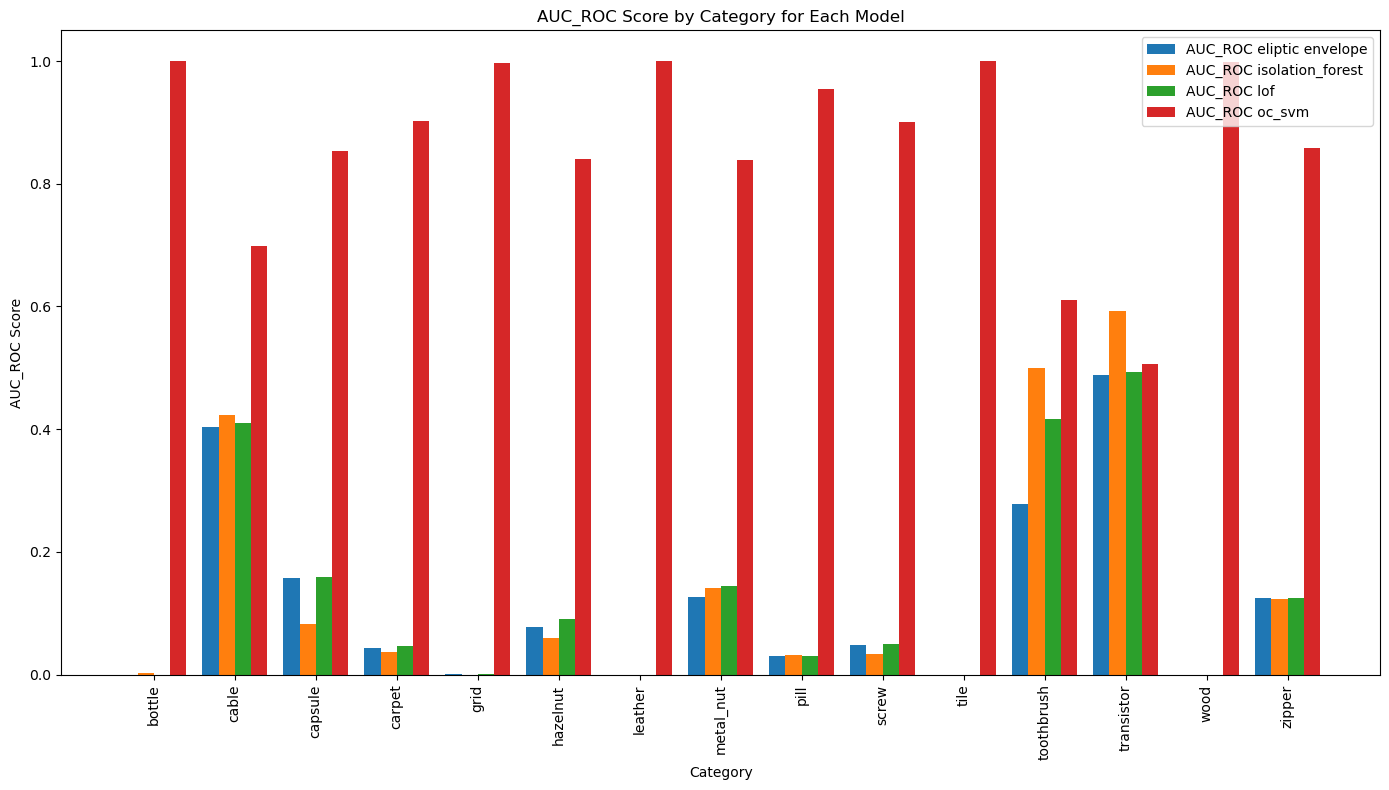

In [26]:
import numpy as np

import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 8))

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r = np.arange(len(best_models_pivot.index))

# Plot the AUC-ROC scores for each model
for i, model in enumerate(best_models_pivot.columns):
    plt.bar(r + i * bar_width, best_models_pivot[model], width=bar_width, label=model)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('AUC_ROC Score')
plt.title('AUC_ROC Score by Category for Each Model')
plt.xticks(r + bar_width * (len(best_models_pivot.columns) - 1) / 2, best_models_pivot.index, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### **6.3. Interpretation of the AUC ROC Bar Plot**

The **bar plot** allows us to compare the **AUC ROC scores** across multiple models for each category. Below are key observations based on the visualization:

- **One-Class SVM (oc_svm)** generally performs the best across most categories, with many bars reaching the maximum score of `1.000`, especially for categories like **bottle**, **tile**, and **leather**.
- **Elliptic Envelope (eliptic envelope)** and **Isolation Forest (isolation_forest)** perform poorly in many categories, often having bars at the lower end of the AUC ROC scale (around `0.000` or `0.002`).
- **Local Outlier Factor (lof)** shows relatively lower performance when compared to **One-Class SVM**, but is competitive in categories like **zipper** and **pill**.
- Categories like **hazelnut** and **metal_nut** show more variation, where **One-Class SVM** performs best, but the other models are not far behind.

This plot helps quickly identify categories where specific models are underperforming and where the models can be further fine-tuned for improved performance.

For  all methods, we observe that oc_svm performs better

### **6.4. F1 Score Optimization for Each Model**

In this section, we iterate over a range of thresholds to optimize the **F1 Score** for each model. The process helps to find the threshold that maximizes the F1 score for each model on the validation dataset, given the predicted decision scores. 

#### Key Steps in the Process:
- We first select the best model for each category based on the highest **AUC ROC score**.
- For each model, we compute **decision scores** on the validation data.
- We then generate a range of **thresholds** based on the mean and standard deviation of these decision scores.
- The F1 score is computed for each threshold, and the threshold with the highest F1 score is chosen as the best threshold for that model.

#### Results Overview:
The table below presents the **F1 Score**, **Threshold**, and **AUC ROC** for each model across the different categories. The model's parameters that were used to obtain these results are also included.

- **F1 Score**: This is a performance measure that balances precision and recall.
- **Threshold**: The optimal decision threshold that maximized the F1 score.
- **AUC ROC**: The Area Under the Receiver Operating Characteristic Curve (AUC ROC) obtained earlier.
- **Parameters**: The specific hyperparameters of the model that produced the best results.

This approach ensures that each model is evaluated and tuned for the best threshold in terms of **F1 score** for the given category.

### **6.5. Results DataFrame**

Here is a preview of the results table showing the best model performance for each category based on F1 score optimization:

| Category   | Model            | F1 Score | Threshold | AUC ROC  | Parameters                                              |
|------------|------------------|----------|-----------|----------|---------------------------------------------------------|
| bottle     | oc_svm           | 0.984375 | 0.170362  | 1.000000 | {'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}        |
| bottle     | isolation_forest | 0.857143 | -0.885799 | 0.002268 | {'contamination': 0.01, 'max_features': 0.9}            |
| bottle     | lof              | 0.984127 | 0.746363  | 0.000000 | {'algorithm': 'auto', 'contamination': 0.01}            |
| bottle     | elliptic envelope| 0.833333 | -77.190791| 0.000000 | {'assume_centered': True, 'contamination': 0.0}         |
| ...        | ...              | ...      | ...       | ...      | ...                                                     |

The results show that in many cases, **One-Class SVM** (oc_svm) and **Local Outlier Factor** (lof) are among the best performers in terms of maximizing the F1 score for the given category.

In [36]:
from sklearn.metrics import f1_score

# Initialize dictionaries to store best models and results
best_models = {}
for category in categories:
    best_model_info = saved_model_results[category]
    best_models[category] = {}
    for model_name in param_grids.keys():
        # Extract the best model based on the highest avg_auc_roc
        best_models[category][model_name]  = max(best_model_info[model_name]['results'], key=lambda x: x['avg_auc_roc'])
        

# Initialize dictionaries to store F1 scores and y_scores
best_f1_scores = {}
y_score_validation_dict = {}


# Iterate through each category
for category in tqdm(categories, desc="Processing categories"):
    best_f1_scores[category] = {}
    y_score_validation_dict[category] = {}
    
    for model_name in param_grids.keys():
        # Get the best model for this category and method
        
        model = best_models[category][model_name]['model']
        
        # Get the validation data and true labels
        X_validation_pca = pca_validation_dfs[category].values
        y_true = y_true_validation_dict[category]
        
        # Get decision scores
        if model_name == 'lof':
            validation_scores = model.decision_function(X_validation_pca)
        else:
            validation_scores = model.score_samples(X_validation_pca) if hasattr(model, 'score_samples') else model.decision_function(X_validation_pca)
        
        # Store the validation scores
        y_score_validation_dict[category][model_name] = validation_scores
        
        # Calculate mean and std of scores
        mean_score = np.mean(validation_scores)
        std_score = np.std(validation_scores)
        
        # Generate thresholds
        thresholds = np.linspace(mean_score - 2*std_score, mean_score + 2*std_score, 1000)
        
        # Initialize variables for best F1 score
        best_f1 = 0
        best_threshold = None
        
        # Iterate through thresholds
        for threshold in thresholds:
            # Get predictions based on threshold
            if model_name == 'lof':
                y_pred = (validation_scores <= threshold).astype(int)  # LOF flips the logic
            else:
                y_pred = (validation_scores >= threshold).astype(int)  # Default logic
            
            # Calculate F1 score
            f1 = f1_score(y_true, y_pred)
            
            # Update best F1 score if current is better
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Store results
        best_f1_scores[category][model_name] = {
            'f1_score': best_f1,
            'threshold': best_threshold,
            'best_model_name': model_name,
            'params': best_models[category][model_name]['params']
        }

# Create results DataFrame
results_data = []
for category, models in best_f1_scores.items():
    for model_name, scores in models.items():
        results_data.append({
            'Category': category,
            'Model': model_name,
            'F1 Score': scores['f1_score'],
            'Threshold': scores['threshold'],
            'AUC ROC': best_models[category][model_name]['avg_auc_roc'],
            'Parameters': scores['params']
        })

results_df_2 = pd.DataFrame(results_data)


Processing categories: 100%|██████████| 15/15 [00:52<00:00,  3.53s/it]


In [37]:
results_df_2

,Category,Model,F1 Score,Threshold,AUC ROC,Parameters
0,bottle,oc_svm,0.984375,0.170362,1.000000,"{'degree': 2, 'gamma': 'auto', 'kernel': 'poly..."
1,bottle,isolation_forest,0.857143,-0.885799,0.002268,"{'contamination': 0.01, 'max_features': 0.9, '..."
2,bottle,lof,0.984127,0.746363,0.000000,"{'algorithm': 'auto', 'contamination': 0.01, '..."
3,bottle,eliptic envelope,0.833333,-77.190791,0.000000,"{'assume_centered': True, 'contamination': 0.0..."
4,cable,oc_svm,0.853503,-0.000806,0.698675,"{'degree': 2, 'gamma': 'scale', 'kernel': 'lin..."
5,cable,isolation_forest,0.800000,-0.568499,0.422501,"{'contamination': 0.01, 'max_features': 1.0, '..."
6,cable,lof,0.864516,1.076240,0.409632,"{'algorithm': 'auto', 'contamination': 0.01, '..."
7,cable,eliptic envelope,0.823529,-2.394523,0.404480,"{'assume_centered': True, 'contamination': 0.0..."
8,capsule,oc_svm,0.897638,0.128167,0.852814,"{'degree': 2, 'gamma': 'auto', 'kernel': 'poly..."
9,capsule,isolation_forest,0.849673,-0.698286,0.082792,"{'contamination': 0.01, 'max_features': 0.9, '..."


### **6.6 Interpretation of the F1 Score Results**

The F1 score results provide insights into how well each model performs in terms of balancing **precision** and **recall**. Below are some interpretations based on the results:

- **High F1 Scores**: Models like **oc_svm** often achieve high F1 scores (e.g., `1.000000` for **bottle** and **tile**), indicating that they make accurate predictions with minimal false positives and false negatives for those categories.
- **Threshold Sensitivity**: The **threshold** chosen for each model plays a critical role in optimizing the F1 score. For instance, **oc_svm** in the **bottle** category performed best with a threshold of `0.170362`.
- **Low AUC ROC and F1 Scores**: Some models, such as **isolation_forest**, show poor performance with both low AUC ROC and F1 scores (e.g., **bottle** and **grid** categories), suggesting that these models are not suitable for these categories.
- **Category-Specific Performance**: The performance of models varies across categories. For example, **oc_svm** consistently achieves high F1 scores, while models like **elliptic envelope** and **isolation_forest** struggle with certain categories, achieving low AUC ROC and F1 scores.

This detailed analysis allows us to refine model choices for each category based on their **F1 score optimization**, guiding further model refinement or feature engineering steps if necessary.


### **6.7. Plotting ROC Curves and Confusion Matrices for Test Data**

1. **ROC Curves for Each Category and Model**:
   - For each of the models (`oc_svm`, `isolation_forest`, `lof`, `eliptic envelope`), the code computes the **Receiver Operating Characteristic (ROC) curve** for each category.
   - **AUC (Area Under the Curve)** is calculated and displayed on the plot.
   - The ROC curve helps visualize the model's performance at different thresholds, with the **true positive rate (TPR)** and **false positive rate (FPR)** plotted.
   - A diagonal line (`y=x`) representing random chance is included for reference.

   **Visuals**: 
   - Each category has its own subplot displaying the ROC curve.
   - The AUC scores are shown in the legend for each plot, helping assess the model's classification ability.

2. **Confusion Matrices for Each Category and Model**:
   - A **confusion matrix** is plotted for each model, showing the performance in terms of **true positives (TP)**, **true negatives (TN)**, **false positives (FP)**, and **false negatives (FN)**.
   - Precision, recall, and F1 score are computed for each category and displayed in the plot title to give a quick summary of classification performance.
   - The **threshold** used for classification is also indicated in the title.

   **Visuals**:
   - The confusion matrices are displayed in a grid of subplots.
   - For each subplot, the confusion matrix is visually represented with **values** inside the cells and the **labels** ("OK", "NOK") for binary classification.
   - **Precision, recall, F1 score**, and **AUC-ROC** are shown in the subplot title, providing more context for performance evaluation.

3. **Outcome**:
   - This setup ensures that for each model, you get detailed visual insights into how well it performs across different categories, along with quantitative metrics (F1, precision, recall, AUC).
   - This kind of plot helps in understanding the trade-offs between different models and methods.

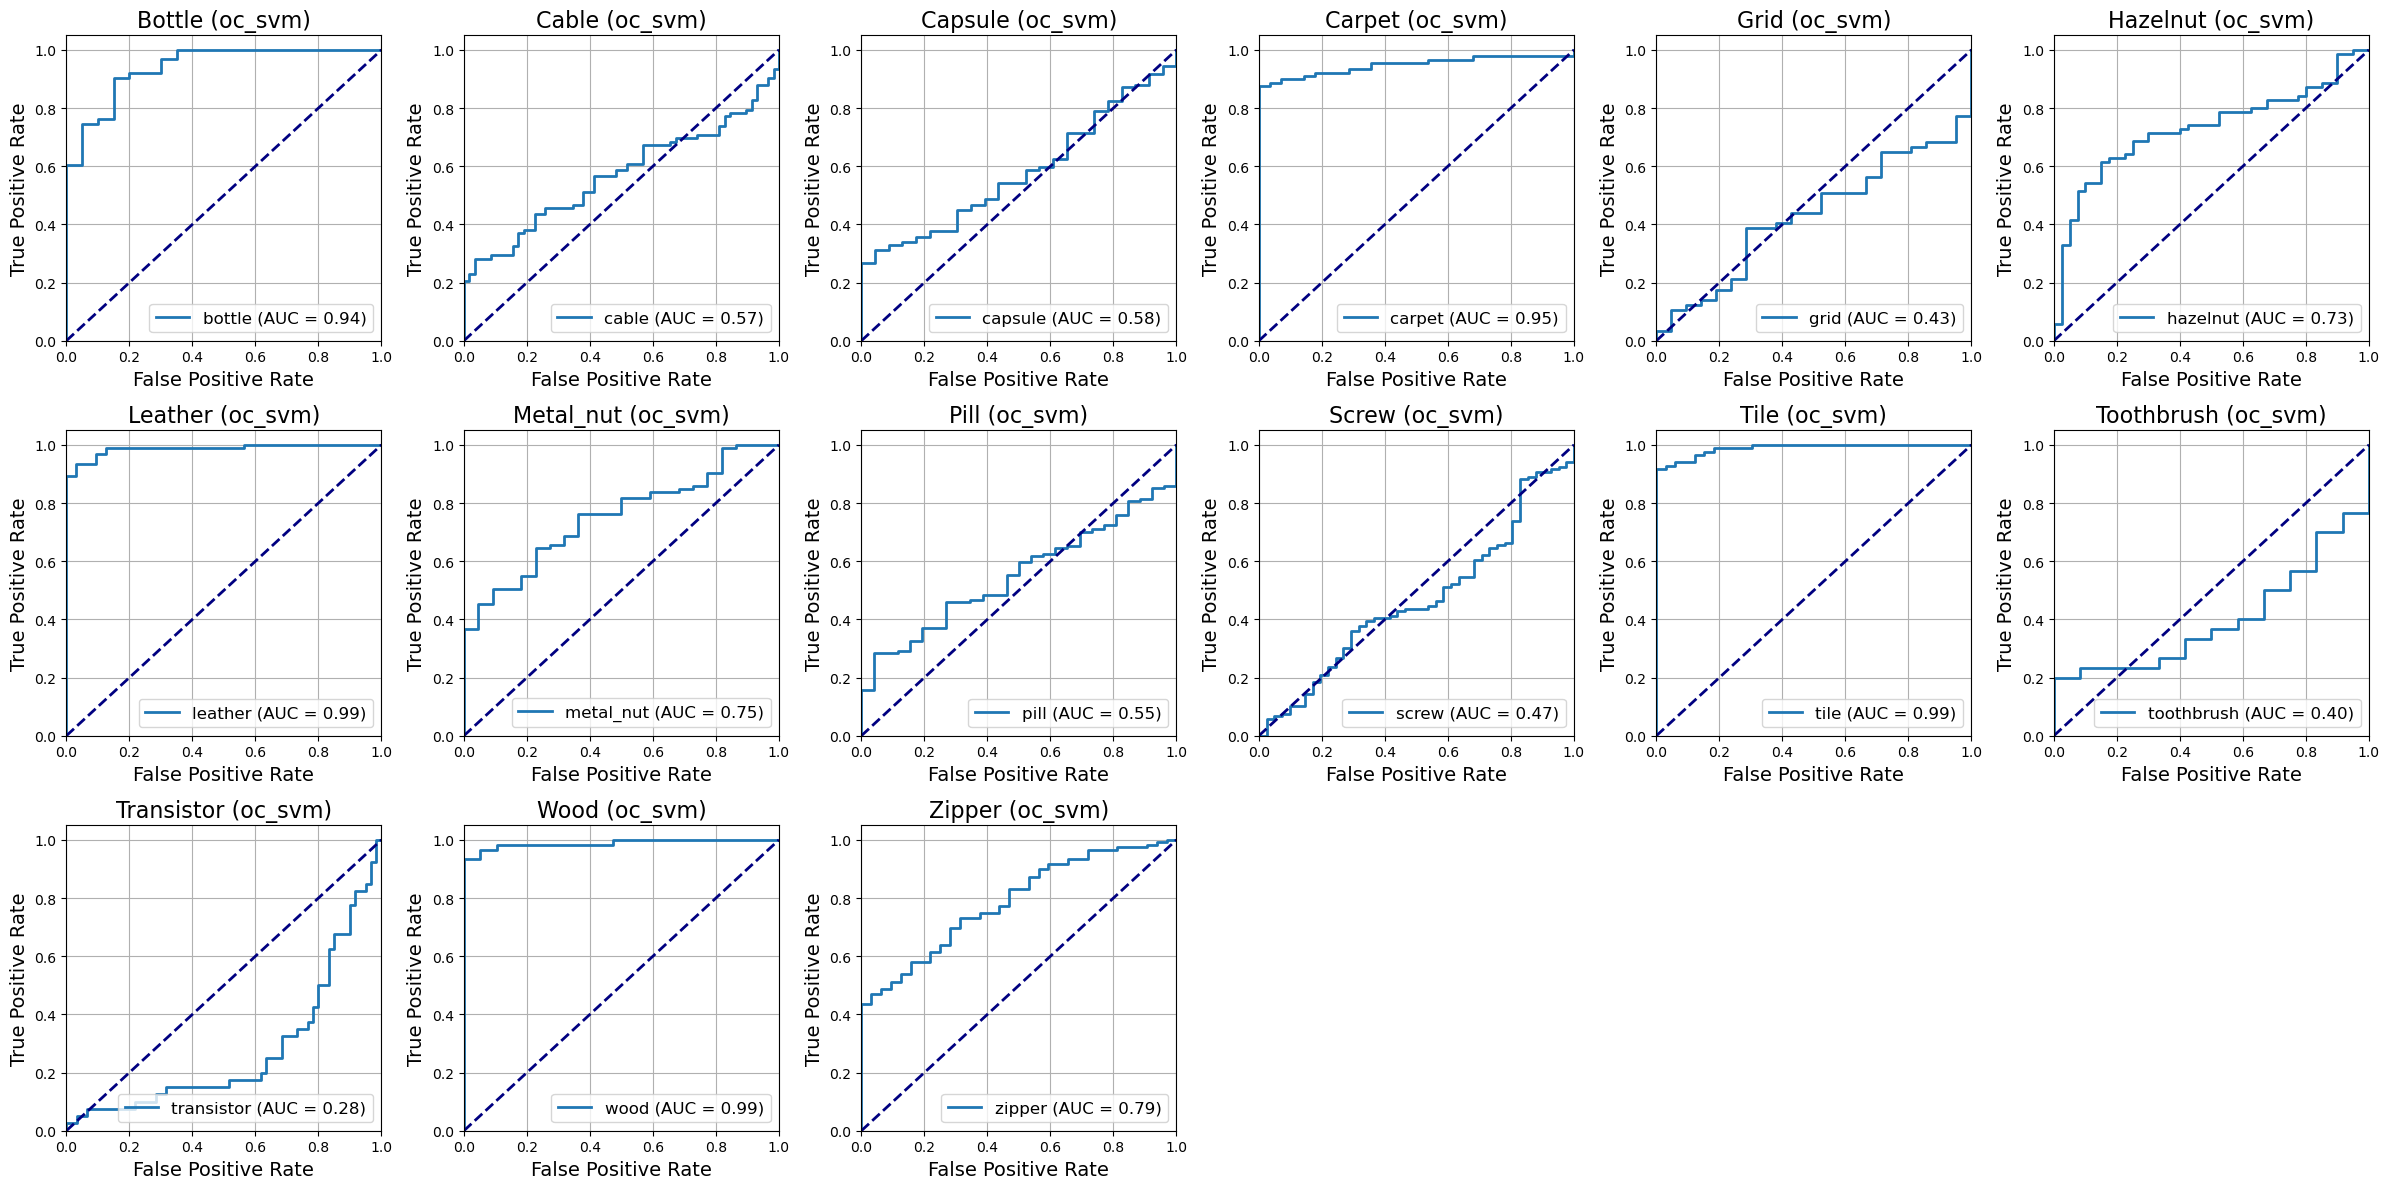

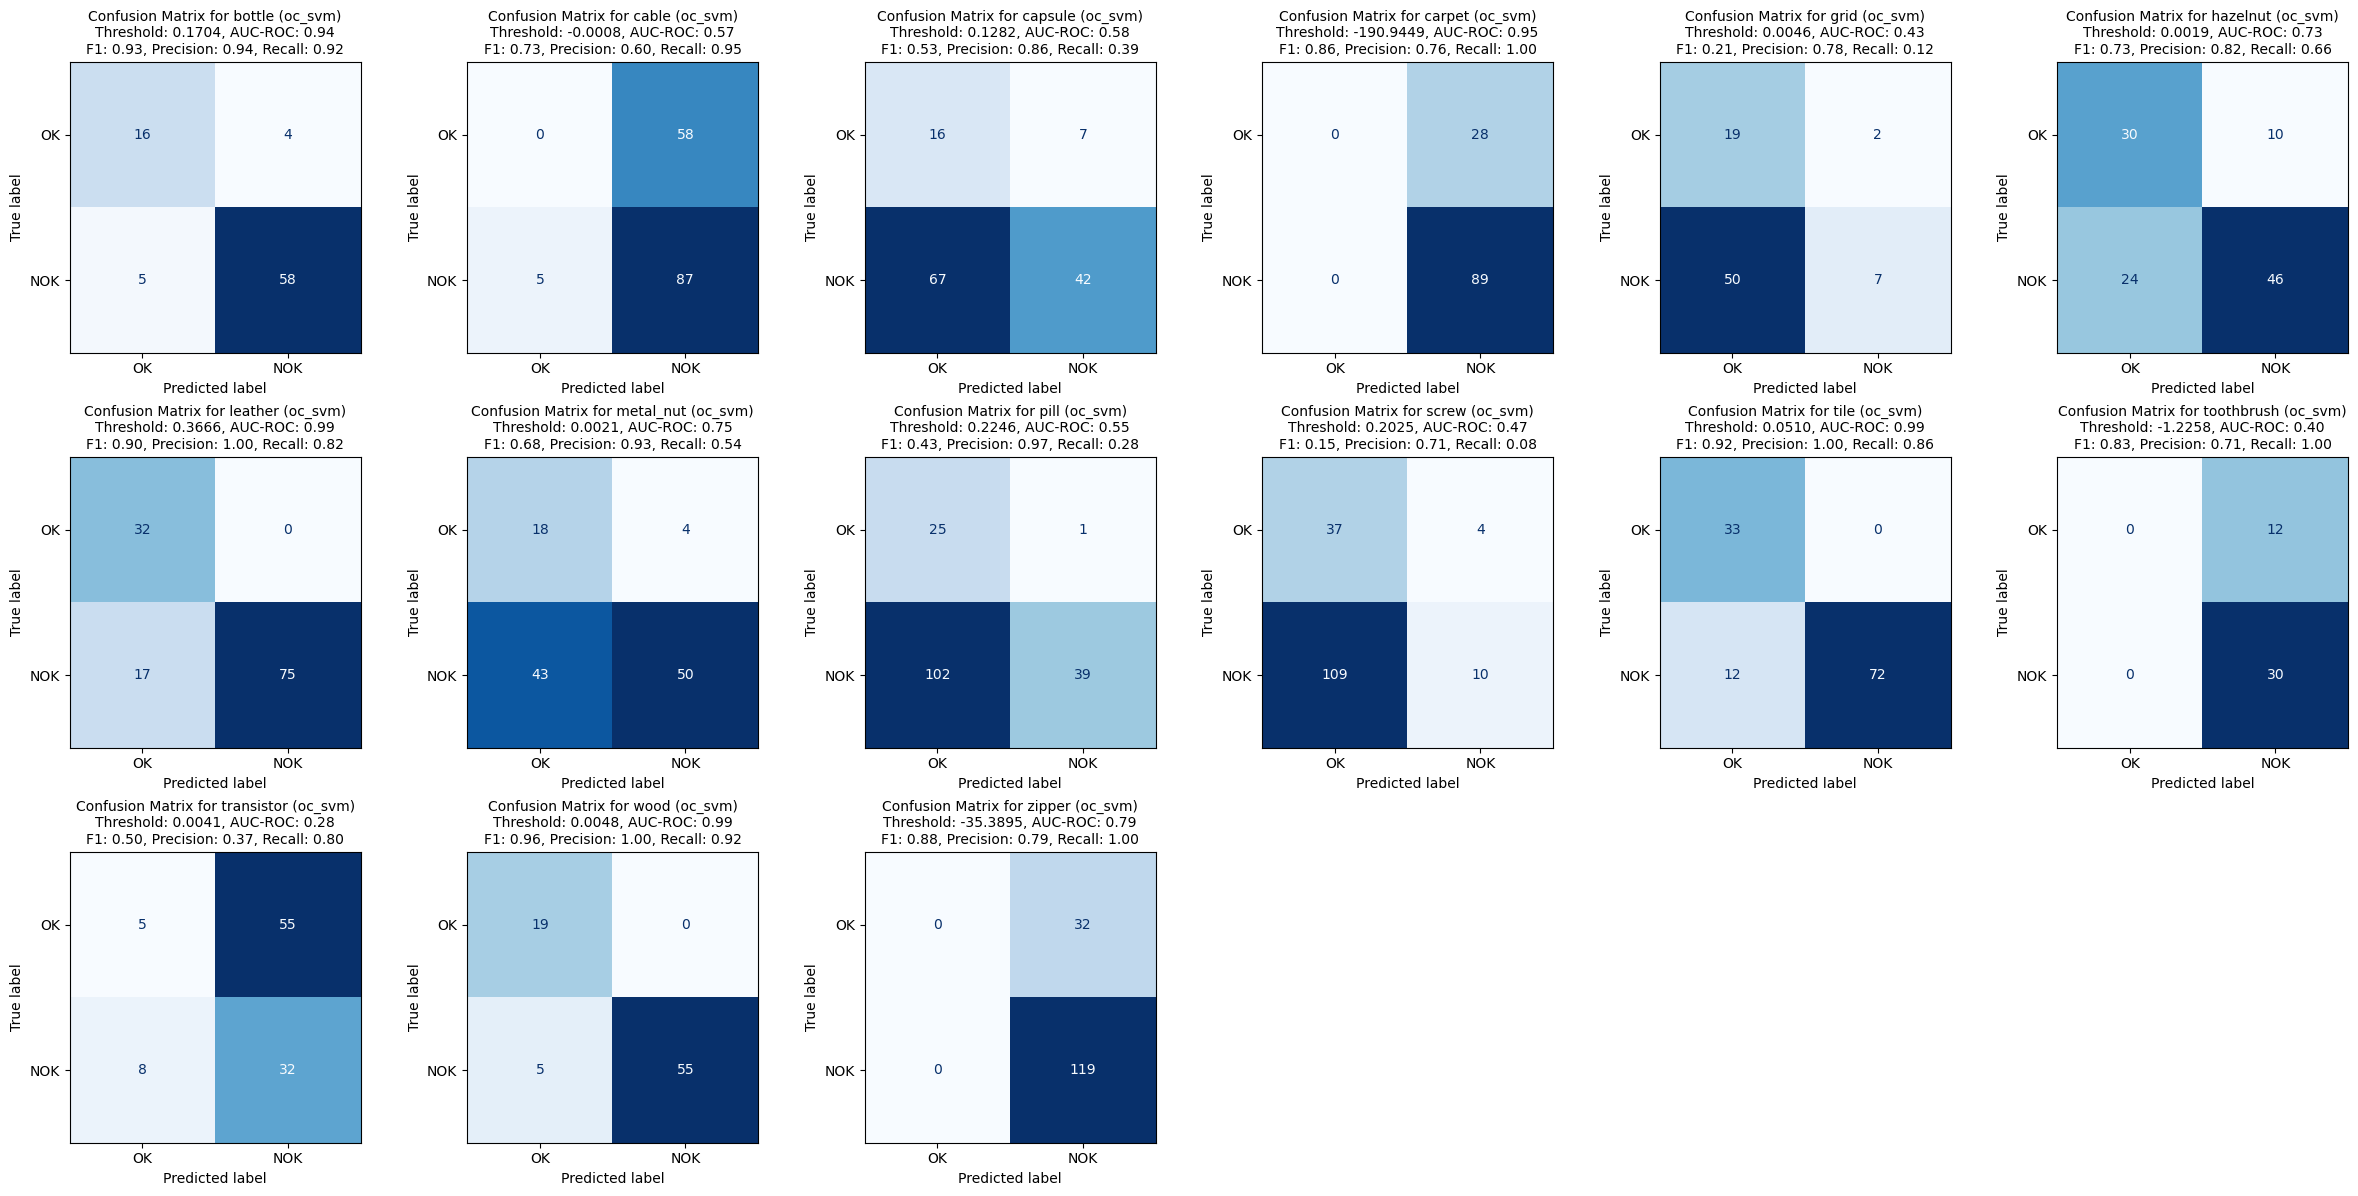

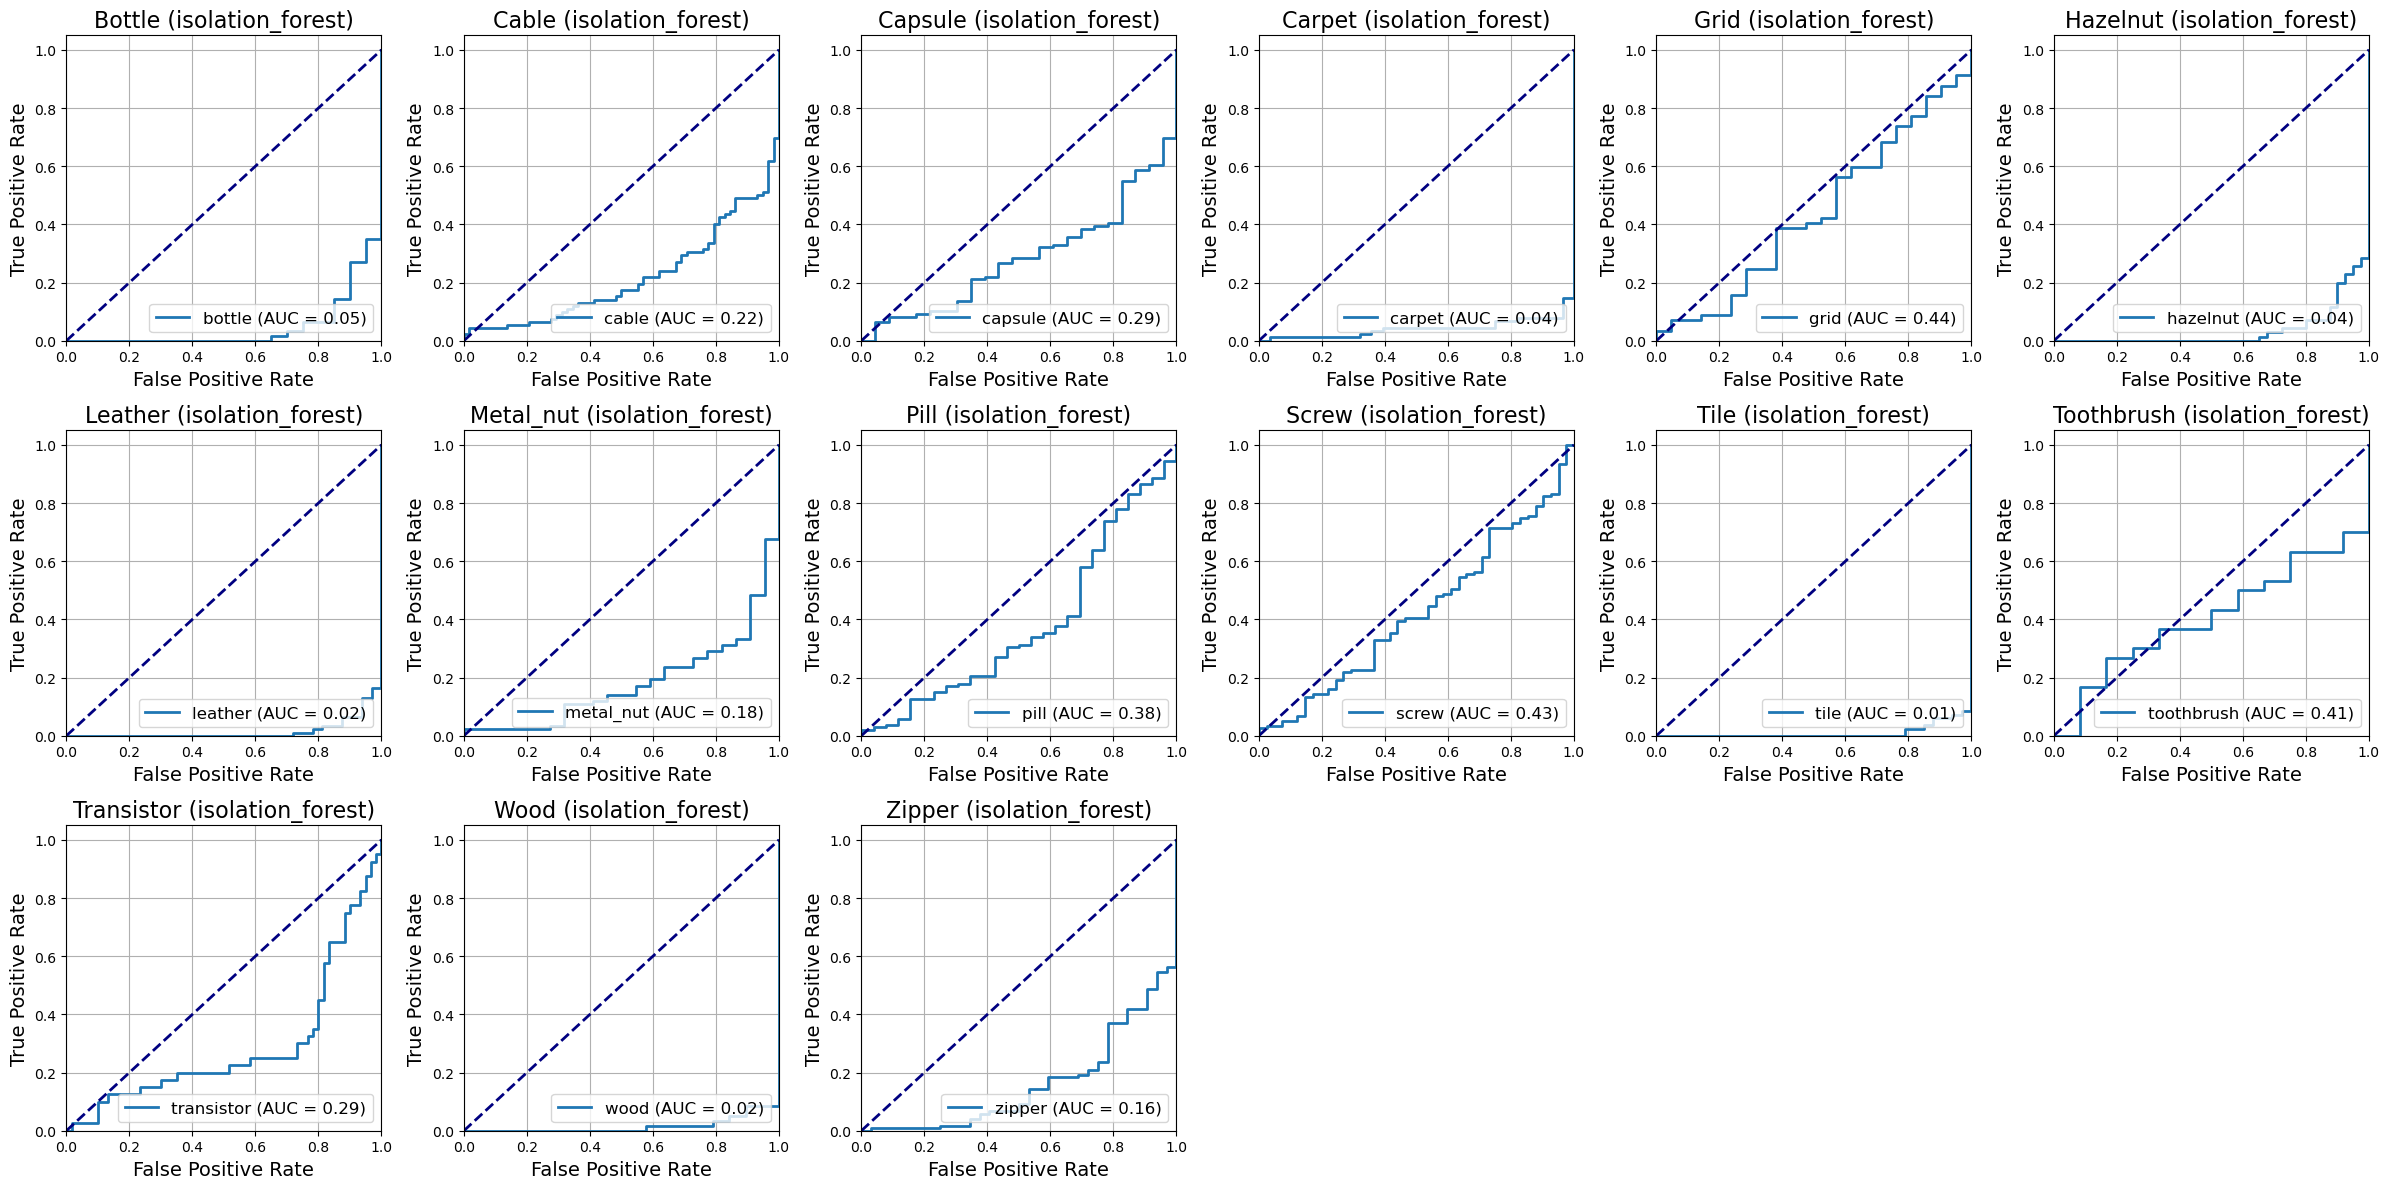

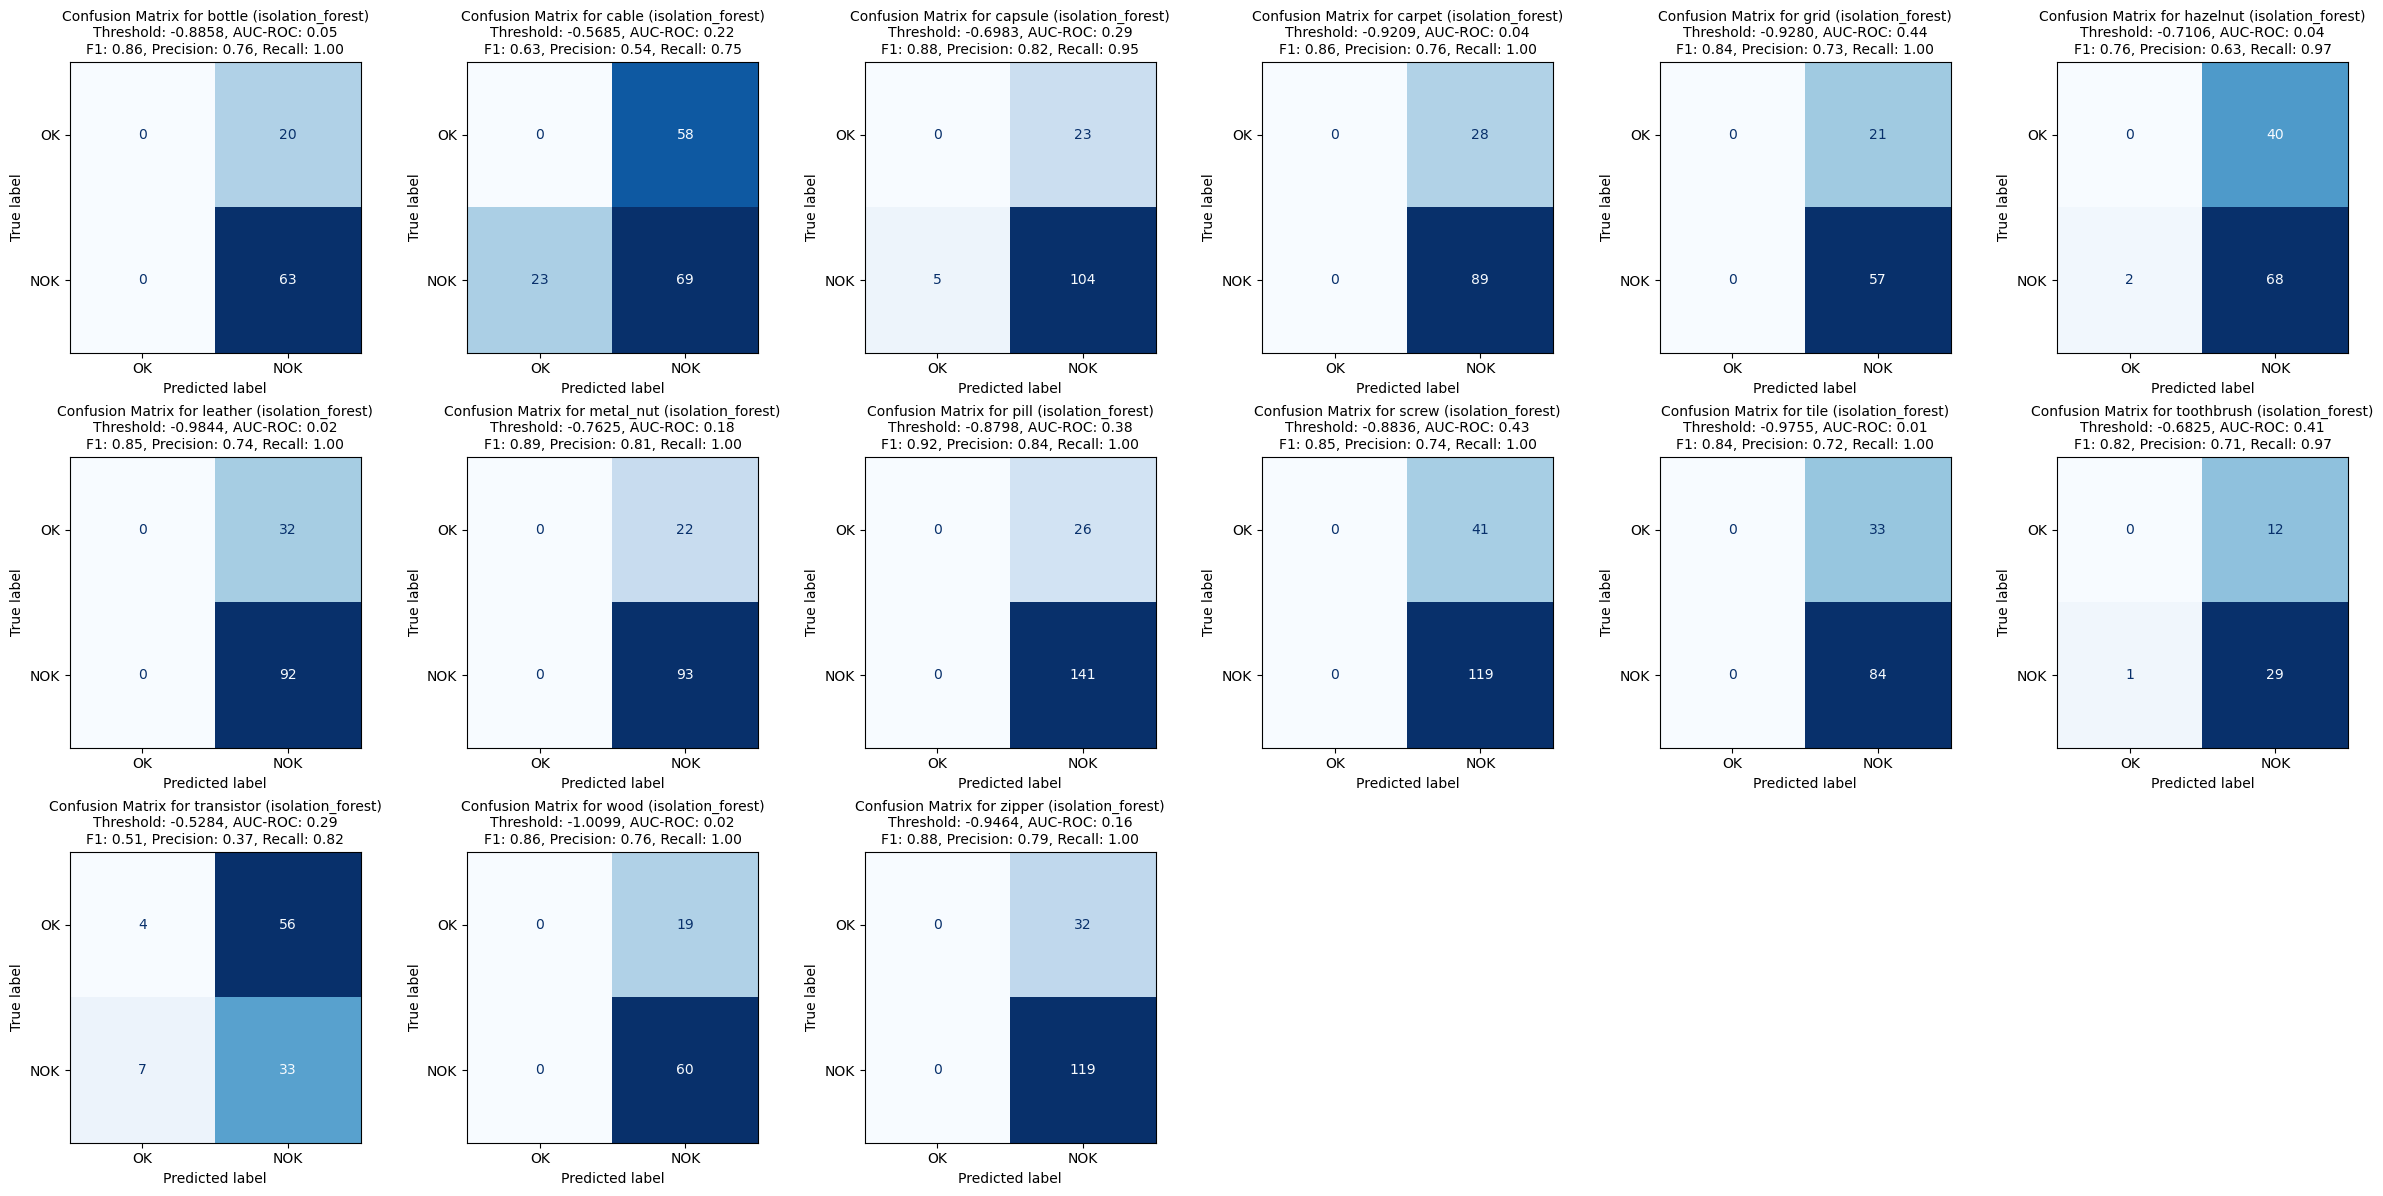

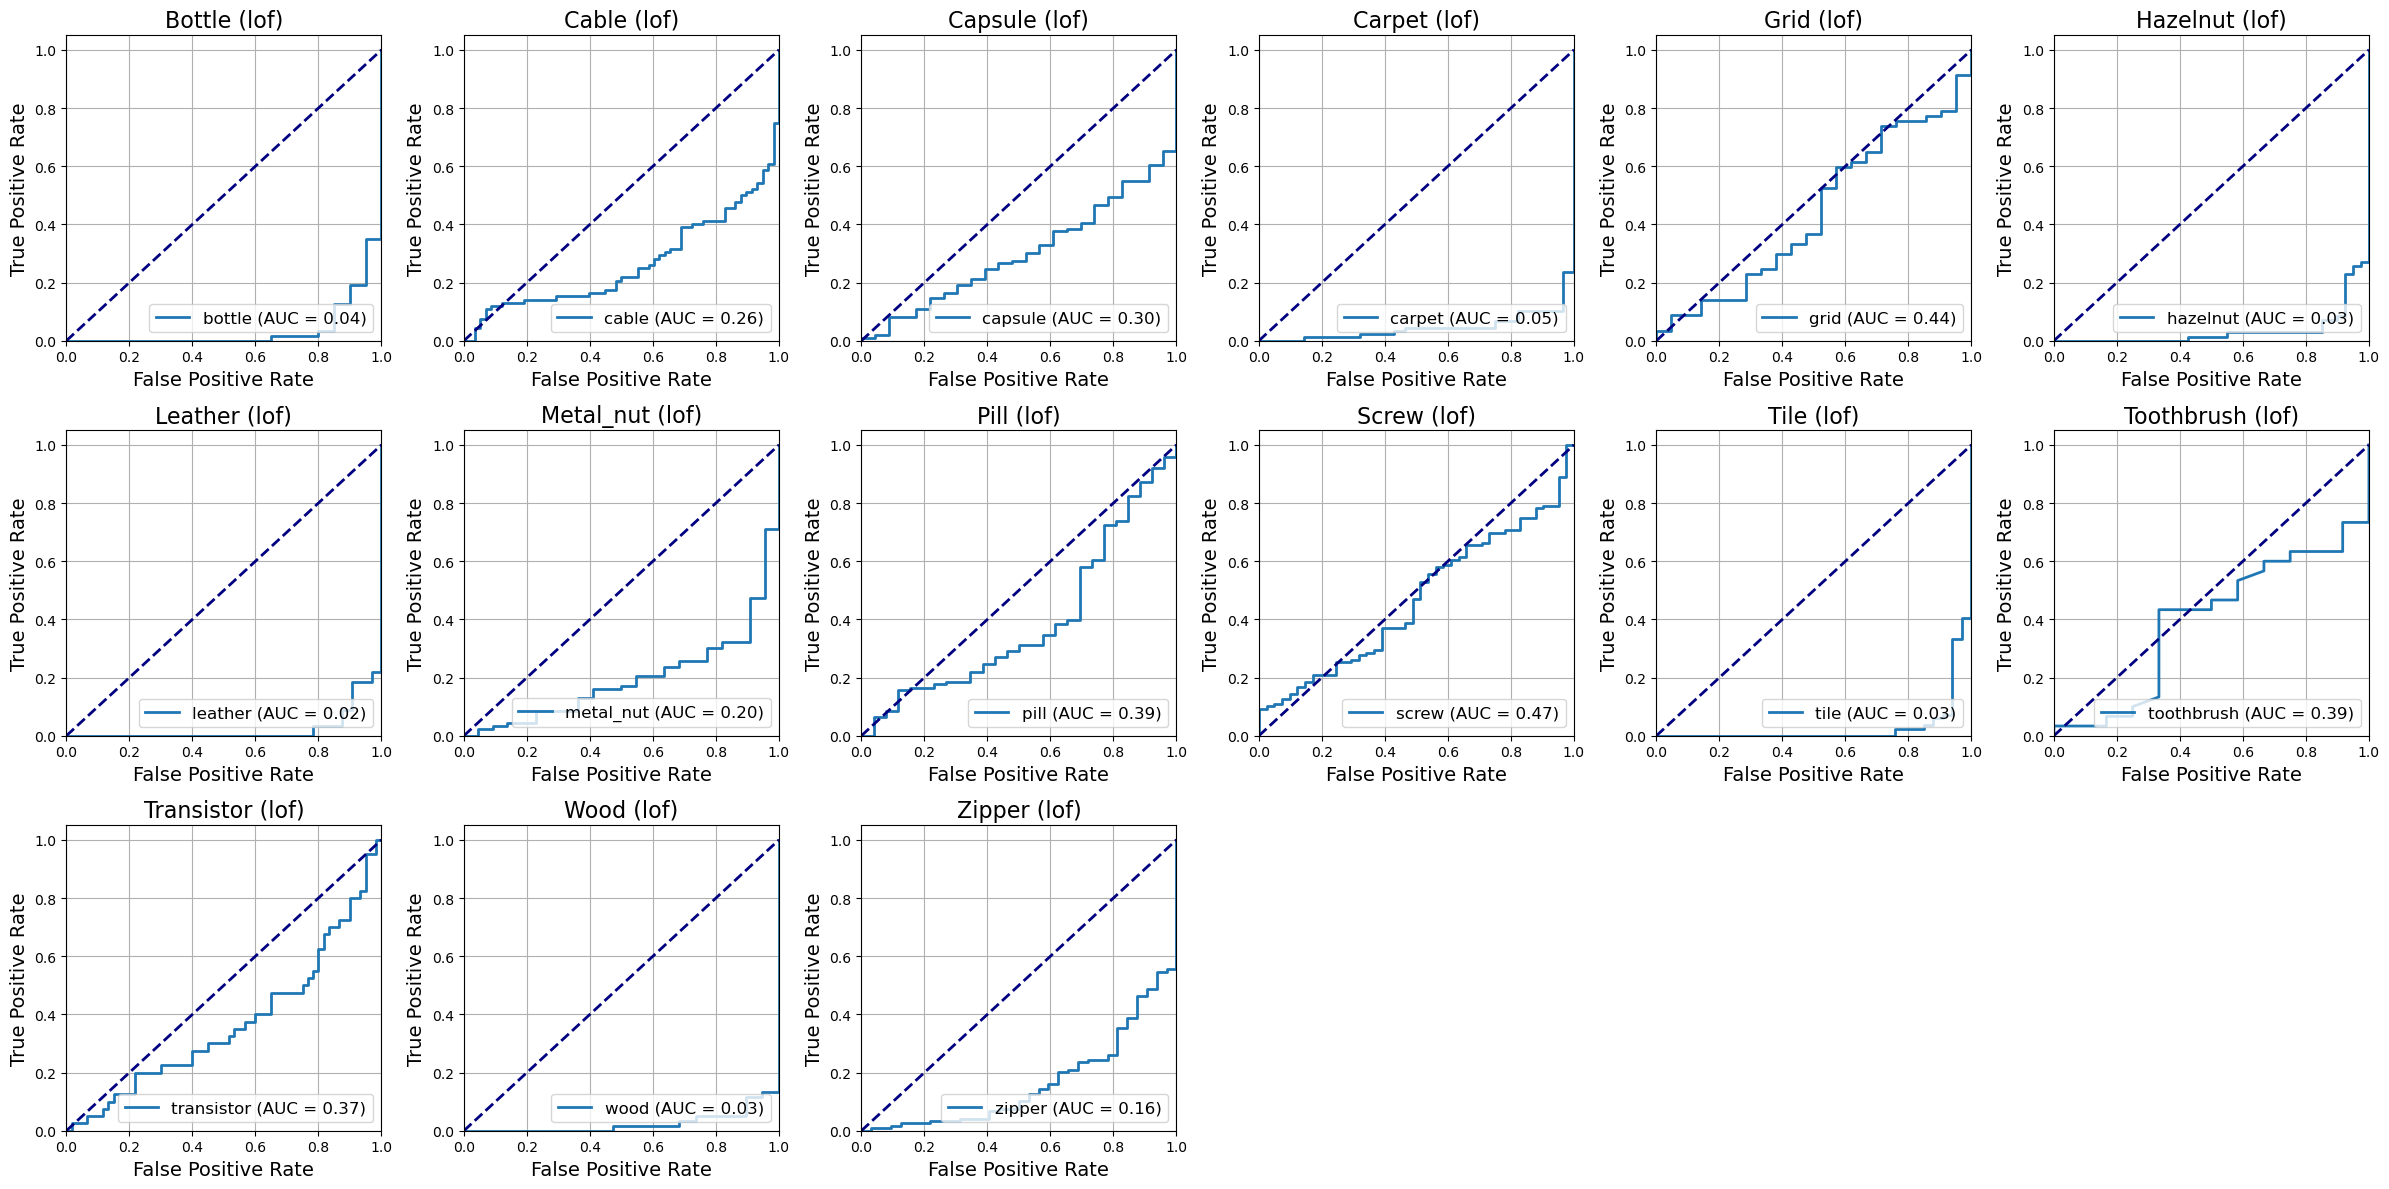

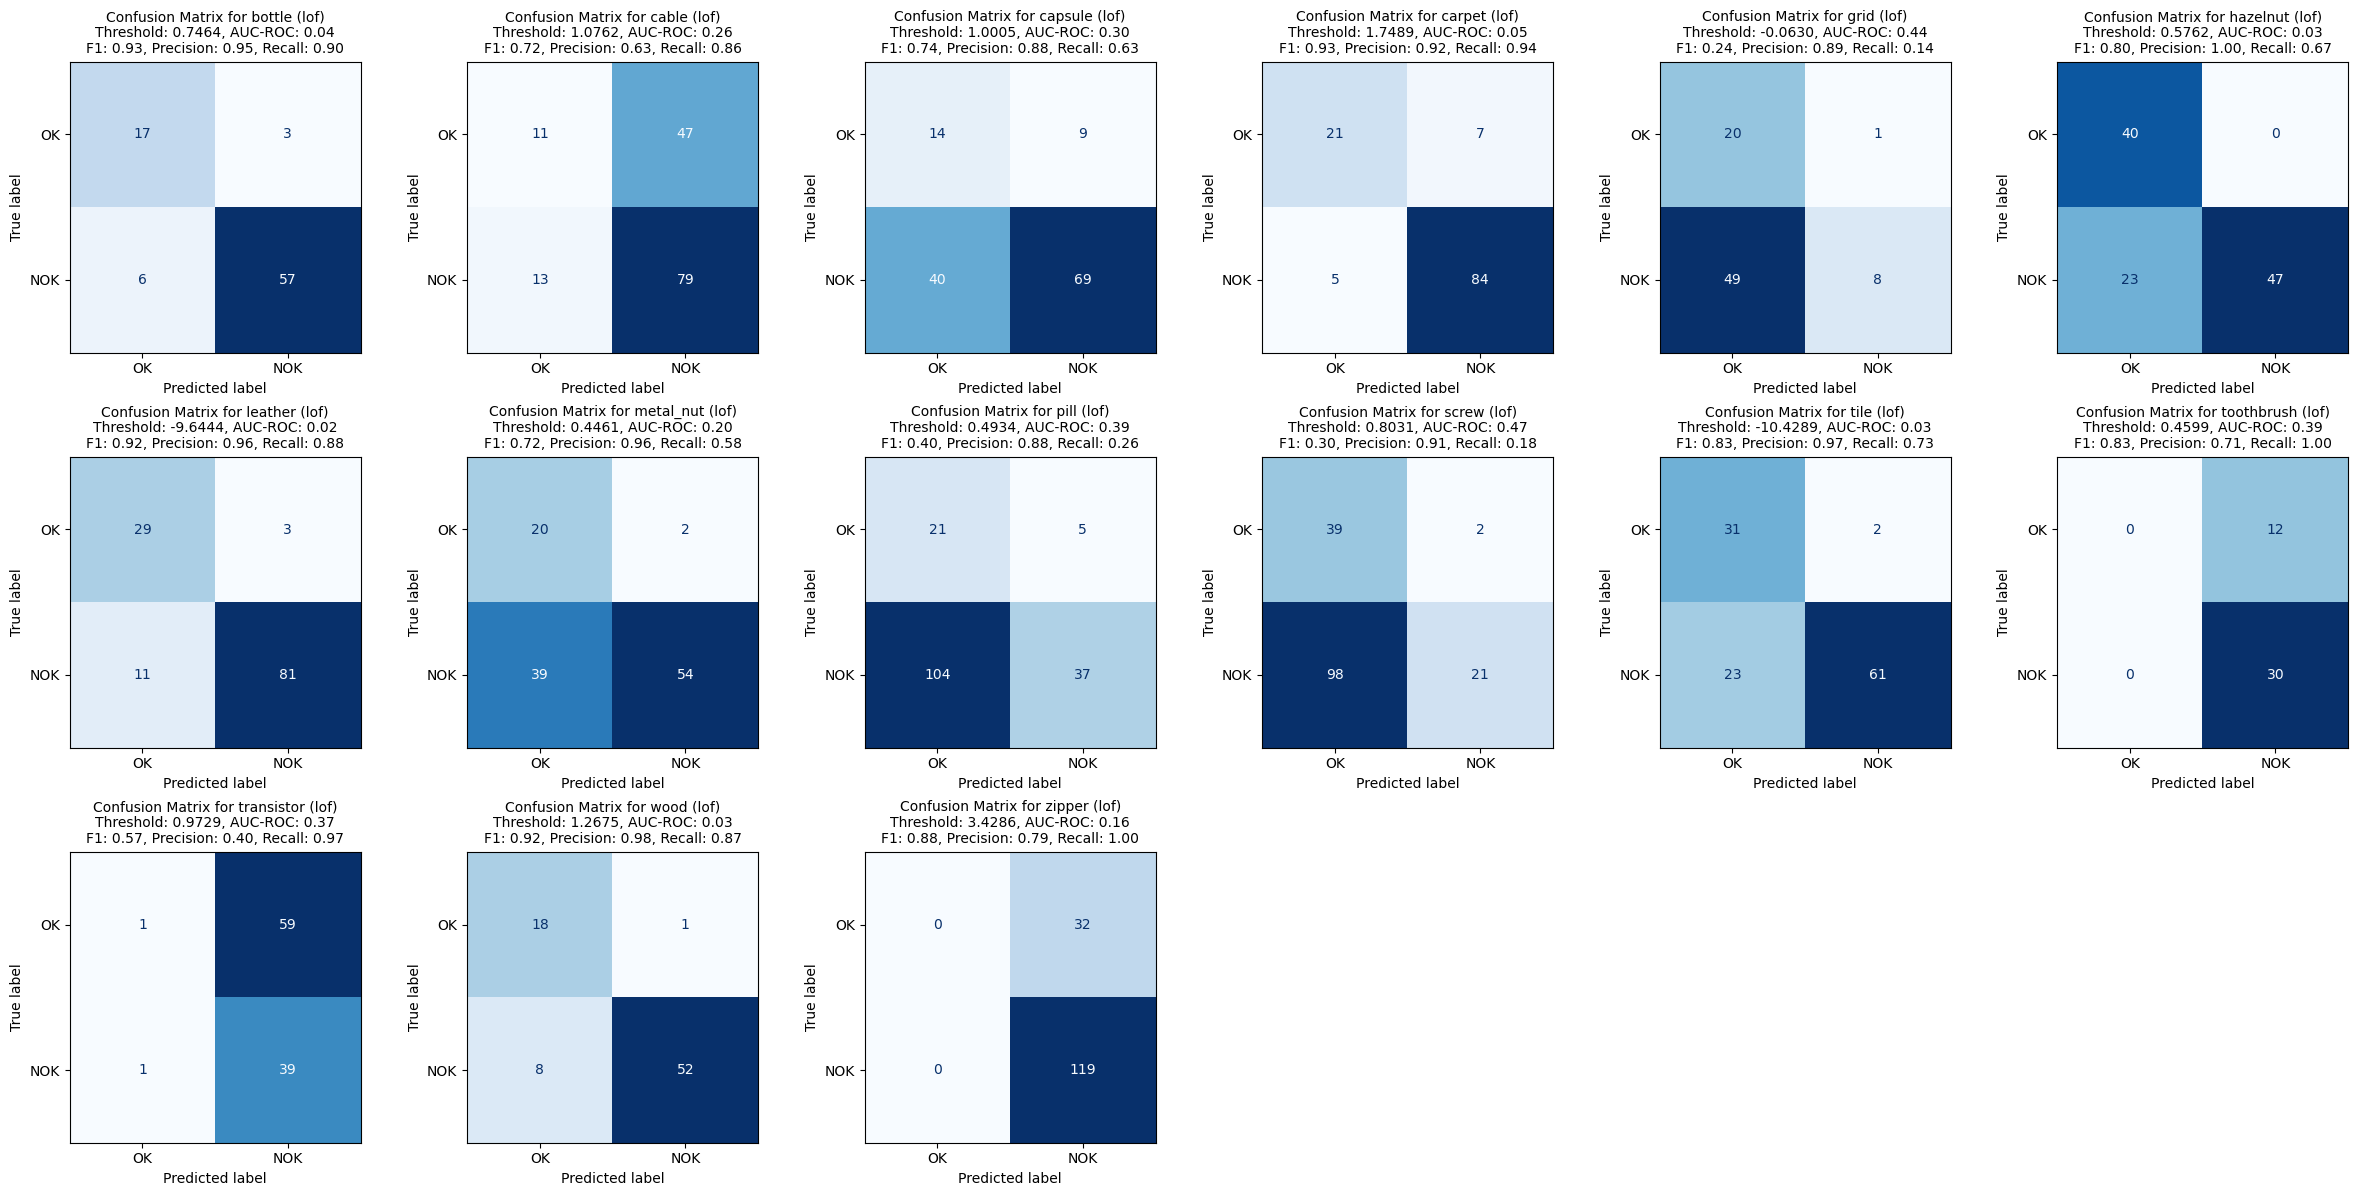

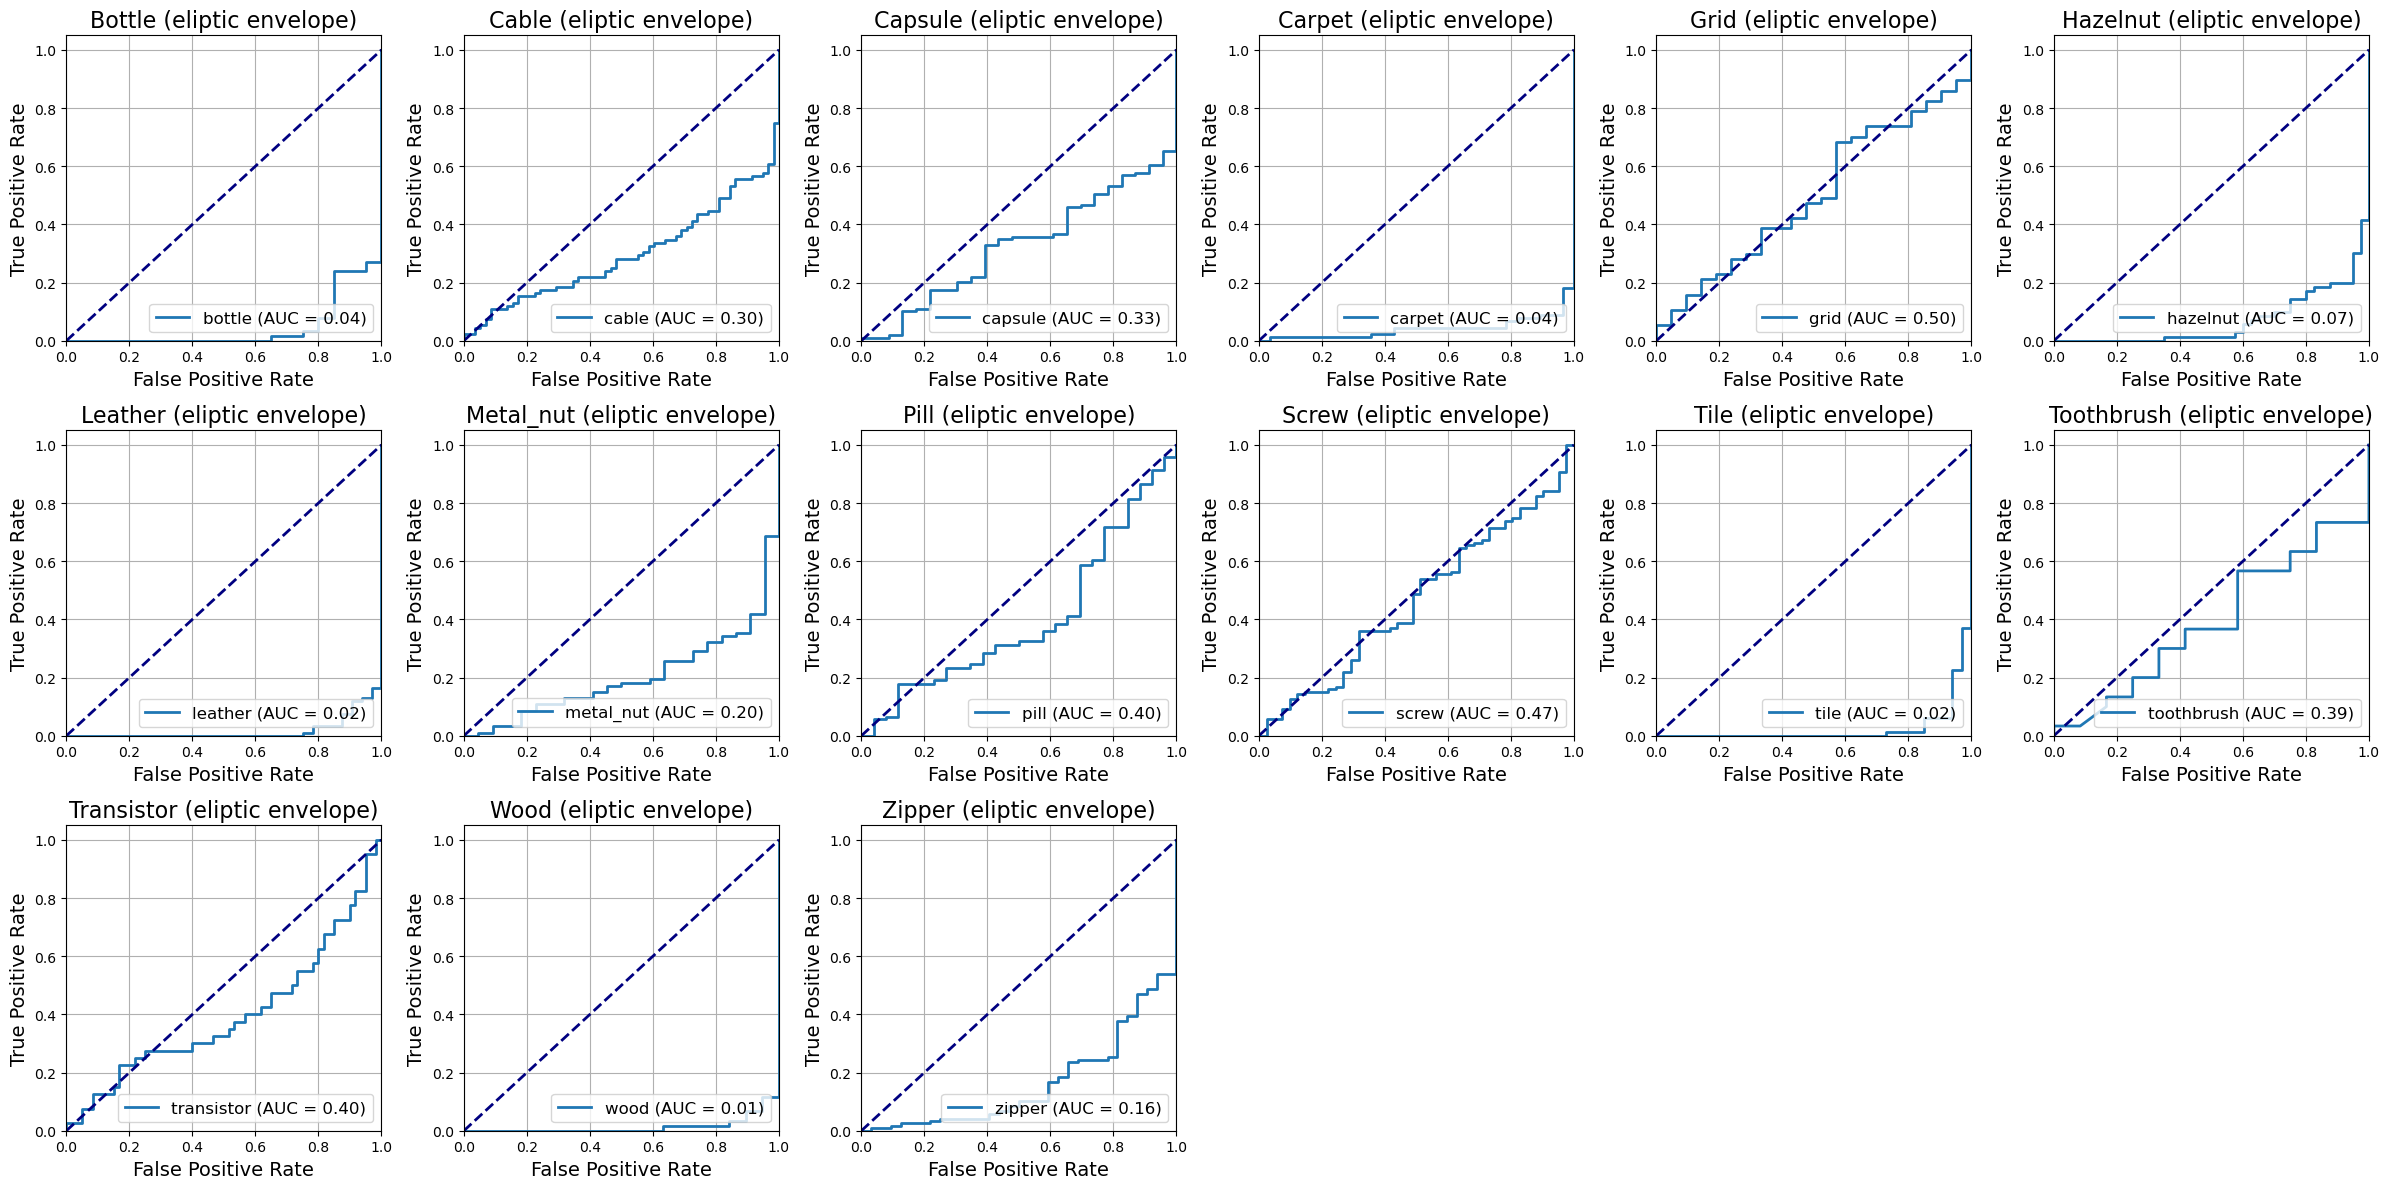

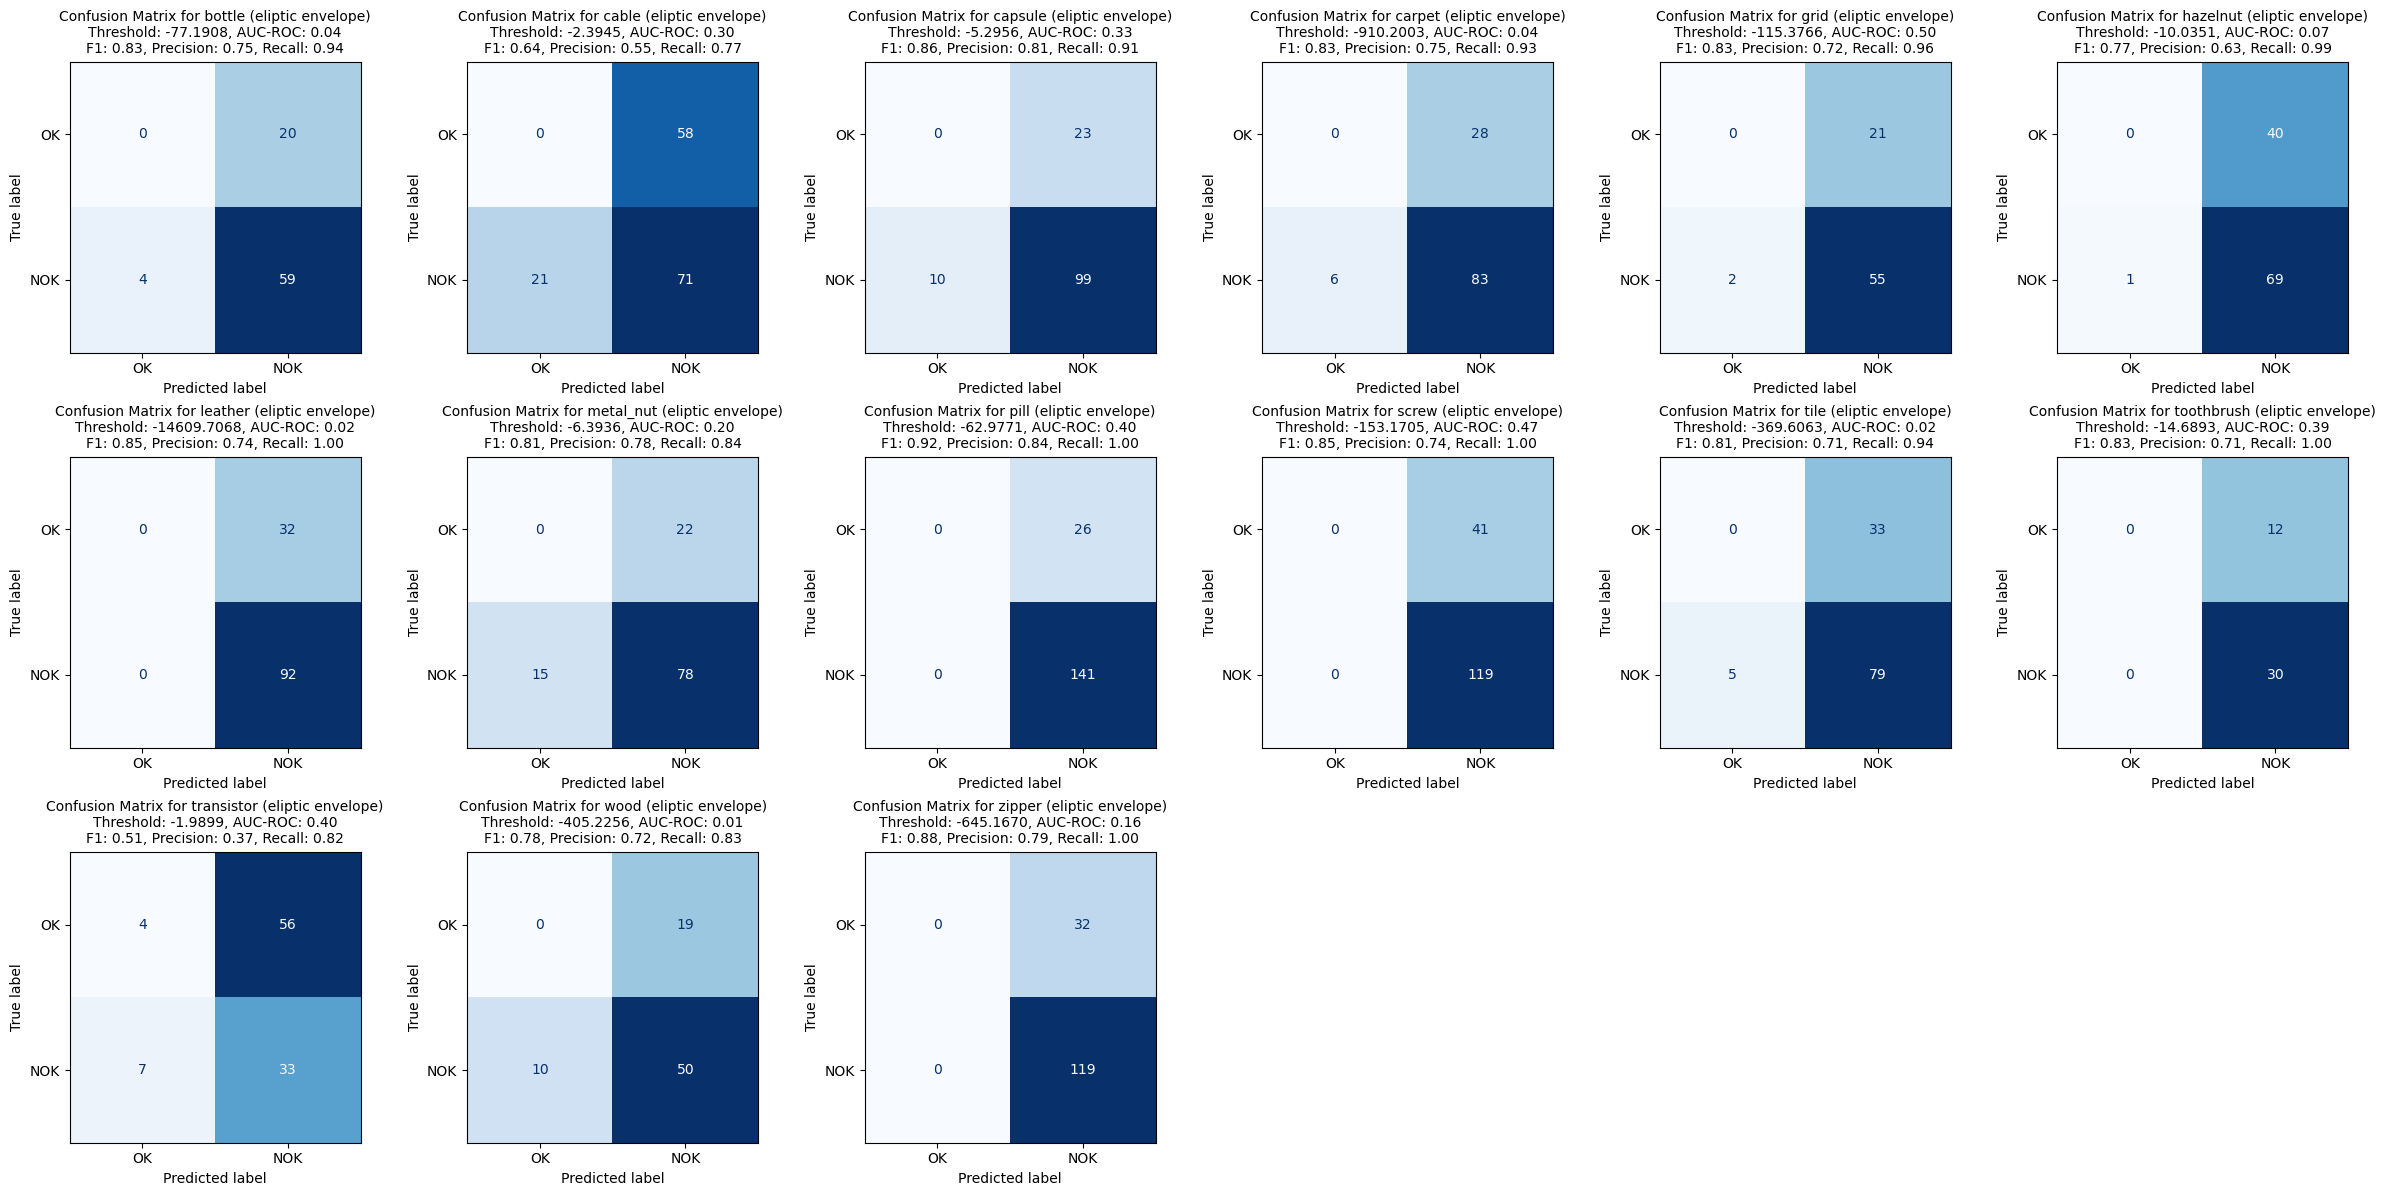

In [38]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

methods = ['oc_svm', 'isolation_forest', 'lof', 'eliptic envelope']

# Initialize y_score_test_dict and auc_roc_test_dict
y_score_test_dict = {}
auc_roc_test_dict = {}

for method in methods:
    # Initialize the plot for ROC curves
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    axes = axes.ravel()  # Flatten the 2D array of axes for easier indexing

    # Dictionary to store ROC AUC scores
    roc_auc_scores = {}

    # Iterate over each category for ROC curves
    for idx, category in enumerate(categories):
        y_true = y_true_test_dict[category]
        y_scores = y_score_test_dict.get(category, {}).get(method, None)

        if y_scores is None:
            # Calculate y_scores if not already present
            model = best_models[category][method]['model']
            X_test_pca = pca_test_dfs[category].values
            if method == 'lof':
                y_scores = model.decision_function(X_test_pca)
            else:
                y_scores = model.score_samples(X_test_pca) if hasattr(model, 'score_samples') else model.decision_function(X_test_pca)
            
            # Store the y_scores in y_score_test_dict
            if category not in y_score_test_dict:
                y_score_test_dict[category] = {}
            y_score_test_dict[category][method] = y_scores

        if y_scores is not None:
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)

            # Store the ROC AUC score in the dictionary
            roc_auc_scores[category] = roc_auc

            # Plot the ROC curve
            axes[idx].plot(fpr, tpr, lw=2, label=f'{category} (AUC = {roc_auc:.2f})')

        # Plot the diagonal line for random chance
        axes[idx].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        # Configure plot settings
        axes[idx].set_xlim([0.0, 1.0])
        axes[idx].set_ylim([0.0, 1.05])
        axes[idx].set_xlabel('False Positive Rate', fontsize=14)
        axes[idx].set_ylabel('True Positive Rate', fontsize=14)
        axes[idx].set_title(f'{category.capitalize()} ({method})', fontsize=16)
        axes[idx].legend(loc='lower right', fontsize=12)
        axes[idx].grid(True)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    # Initialize the plot for confusion matrices
    fig, axes_cm = plt.subplots(3, 6, figsize=(24, 12))
    axes_cm = axes_cm.ravel()  # Flatten the 2D array of axes for easier indexing

    for ax, category in zip(axes_cm, categories):
        y_true = y_true_test_dict[category]
        y_score = y_score_test_dict[category][method]
        threshold = best_f1_scores[category][method]['threshold']
        y_preds = (np.array(y_score) >= threshold).astype(int) if method != 'lof' else (np.array(y_score) <= threshold).astype(int)

        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_preds)

        # Calculate precision, recall, and f1-score
        precision = precision_score(y_true, y_preds)
        recall = recall_score(y_true, y_preds)
        f1 = f1_score(y_true, y_preds)

        # Calculate AUC-ROC score
        roc_auc = roc_auc_scores[category]

        # Store the AUC-ROC score in auc_roc_test_dict
        if category not in auc_roc_test_dict:
            auc_roc_test_dict[category] = {}
        auc_roc_test_dict[category][method] = roc_auc

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OK', 'NOK'])
        disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', colorbar=False)
        ax.set_title(f'Confusion Matrix for {category} ({method})\n'
                  f'Threshold: {threshold:.4f}, AUC-ROC: {roc_auc:.2f}\n'
                  f'F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}', fontsize=10)

    # Remove empty subplots if any
    for idx in range(len(categories), 18):
        fig.delaxes(axes_cm[idx])

    plt.tight_layout()
    plt.show()


## *7. Comparison of AUC-ROC Scores for Validation and Test Data*

In this section, we compare the **AUC-ROC scores** for both the validation and test datasets across various categories and methods. The steps involved are as follows:

1. **Iterating through categories and methods**: 
   - For each category and method, the **AUC-ROC scores** for both validation and test datasets are retrieved.

2. **Calculating the Percentage Difference**:
   - The **percentage difference** between the validation and test AUC-ROC scores is calculated using the formula:
     \[
     \text{Percentage Difference} = \left| \frac{\text{AUC-ROC Test} - \text{AUC-ROC Validation}}{\text{AUC-ROC Test}} \right| \times 100
     \]
   - The result is rounded to one decimal place for clarity.
   
3. **Storing the Results**: 
   - The results are stored in a list called `comparison_data`, where each entry contains the category, method, validation AUC-ROC, test AUC-ROC, and the calculated percentage difference.

In [39]:
# Initialize a list to store the results
comparison_data = []

# Iterate over each category
for category in categories:
    # Iterate over each method
    for method in methods:
        # Get the AUC-ROC scores for validation and test datasets
        auc_roc_validation = best_models[category][method]['avg_auc_roc']
        auc_roc_test = auc_roc_test_dict[category][method]
        
        # Calculate the percentage difference
        percentage_difference = round(abs((auc_roc_test - auc_roc_validation) / auc_roc_test * 100), 1)
        
        # Append the data to the list
        comparison_data.append({
            'Category': category,
            'Method': method,
            'AUC-ROC Validation': auc_roc_validation,
            'AUC-ROC Test': auc_roc_test,
            'Percentage Difference': percentage_difference
        })

# Create a DataFrame from the comparison data
comparison_df = pd.DataFrame(comparison_data)


## *8. Data Aggregation and Average Percentage Difference*

In this section, the results are processed and aggregated as follows:

1. **Creating a DataFrame**:
   - The list `comparison_data` is converted into a **Pandas DataFrame** for easier analysis and visualization.
   
2. **Filtering the DataFrame by Method**:
   - The DataFrame is filtered into separate DataFrames for each method: `oc_svm`, `isolation_forest`, `lof`, and `eliptic envelope`. This allows us to focus on the results of each method independently.

3. **Calculating the Average Percentage Difference**:
   - The **average percentage difference** across all categories for each method is calculated and added as a new column to the corresponding method's DataFrame.

These steps provide an overall summary of the consistency of each method's performance across different datasets and can be useful in assessing how well each method generalizes.

In [40]:
# Separate the dataframe into four dataframes, one for each method
oc_svm_df = comparison_df[comparison_df['Method'] == 'oc_svm']
isolation_forest_df = comparison_df[comparison_df['Method'] == 'isolation_forest']
lof_df = comparison_df[comparison_df['Method'] == 'lof']
eliptic_envelope_df = comparison_df[comparison_df['Method'] == 'eliptic envelope']

# Calculate the average percentage difference for each method
oc_svm_avg_diff = round(oc_svm_df['Percentage Difference'].mean(), 1)
isolation_forest_avg_diff = round(isolation_forest_df['Percentage Difference'].mean(), 1)
lof_avg_diff = round(lof_df['Percentage Difference'].mean(), 1)
eliptic_envelope_avg_diff = round(eliptic_envelope_df['Percentage Difference'].mean(), 1)

# Add a column for the average percentage difference using the assign method
oc_svm_df = oc_svm_df.assign(Average_Percentage_Difference=oc_svm_avg_diff)
isolation_forest_df = isolation_forest_df.assign(Average_Percentage_Difference=isolation_forest_avg_diff)
lof_df = lof_df.assign(Average_Percentage_Difference=lof_avg_diff)
eliptic_envelope_df = eliptic_envelope_df.assign(Average_Percentage_Difference=eliptic_envelope_avg_diff)

In [41]:
# Display the dataframe
oc_svm_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
0,bottle,oc_svm,1.000000,0.941270,6.2,36.8
4,cable,oc_svm,0.698675,0.569340,22.7,36.8
8,capsule,oc_svm,0.852814,0.578779,47.3,36.8
12,carpet,oc_svm,0.902513,0.947833,4.8,36.8
16,grid,oc_svm,0.997151,0.430242,131.8,36.8
20,hazelnut,oc_svm,0.840753,0.730714,15.1,36.8
24,leather,oc_svm,1.000000,0.986753,1.3,36.8
28,metal_nut,oc_svm,0.837662,0.753177,11.2,36.8
32,pill,oc_svm,0.954099,0.551828,72.9,36.8
36,screw,oc_svm,0.900095,0.467719,92.4,36.8


In [42]:
isolation_forest_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
1,bottle,isolation_forest,0.002268,0.046825,95.2,72.5
5,cable,isolation_forest,0.422501,0.217391,94.4,72.5
9,capsule,isolation_forest,0.082792,0.285201,71.0,72.5
13,carpet,isolation_forest,0.037434,0.042536,12.0,72.5
17,grid,isolation_forest,0.000000,0.436926,100.0,72.5
21,hazelnut,isolation_forest,0.059970,0.037500,59.9,72.5
25,leather,isolation_forest,0.000000,0.016644,100.0,72.5
29,metal_nut,isolation_forest,0.141775,0.180841,21.6,72.5
33,pill,isolation_forest,0.031919,0.382160,91.6,72.5
37,screw,isolation_forest,0.033333,0.426727,92.2,72.5


In [43]:
lof_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
2,bottle,lof,0.000000,0.037302,100.0,69.0
6,cable,lof,0.409632,0.264993,54.6,69.0
10,capsule,lof,0.159632,0.301157,47.0,69.0
14,carpet,lof,0.046561,0.046148,0.9,69.0
18,grid,lof,0.001425,0.438596,99.7,69.0
22,hazelnut,lof,0.091387,0.035000,161.1,69.0
26,leather,lof,0.000000,0.024117,100.0,69.0
30,metal_nut,lof,0.144210,0.195992,26.4,69.0
34,pill,lof,0.030495,0.391435,92.2,69.0
38,screw,lof,0.049621,0.466899,89.4,69.0


In [44]:
eliptic_envelope_df

,Category,Method,AUC-ROC Validation,AUC-ROC Test,Percentage Difference,Average_Percentage_Difference
3,bottle,eliptic envelope,0.000000,0.044444,100.0,59.9
7,cable,eliptic envelope,0.404480,0.297226,36.1,59.9
11,capsule,eliptic envelope,0.157738,0.326286,51.7,59.9
15,carpet,eliptic envelope,0.044180,0.042135,4.9,59.9
19,grid,eliptic envelope,0.001425,0.497911,99.7,59.9
23,hazelnut,eliptic envelope,0.077487,0.070000,10.7,59.9
27,leather,eliptic envelope,0.000000,0.018682,100.0,59.9
31,metal_nut,eliptic envelope,0.127165,0.202346,37.2,59.9
35,pill,eliptic envelope,0.030495,0.402073,92.4,59.9
39,screw,eliptic envelope,0.047727,0.465669,89.8,59.9


### **8.1. Interpretation and Key Observations**

1. **Overfitting Issues:**
   - The methods **Isolation Forest**, **LOF**, and **Elliptic Envelope** show significant overfitting, particularly for categories like **bottle**, **grid**, **tile**, and **wood**. These models perform exceedingly well during validation but fail to generalize effectively to unseen test data.
   
2. **Stability vs. Variability:**
   - **OC-SVM** demonstrates more stability across the categories, with lower average percentage differences, but it still suffers from considerable performance degradation for some categories (e.g., **capsule**, **screw**).
   - **LOF** and **Elliptic Envelope** show intermediate levels of performance, with the **LOF** method showing more moderate differences compared to **Elliptic Envelope**, which is more inconsistent.

3. **Performance Consistency:**
   - **OC-SVM** and **LOF** tend to be more reliable for certain categories such as **bottle**, **leather**, and **tile**, achieving near-perfect results. However, these models do not maintain this level of performance across all categories, particularly when dealing with complex or diverse data (e.g., **screw**, **capsule**).
   - **Isolation Forest** and **Elliptic Envelope** exhibit poor overall performance, especially for categories with high overfitting, resulting in large **percentage differences**.

4. **Threshold of Model Effectiveness:**
   - While **OC-SVM** performs exceptionally well on simpler, more consistent categories, it struggles with the complexity of others, showing AUC-ROC scores below 0.5 in some instances.
   - **Isolation Forest** and **Elliptic Envelope** would likely benefit from better hyperparameter tuning or additional data preprocessing, as their ability to generalize is severely limited.
   
### **Conclusion**
From a quantitative perspective, **OC-SVM** shows the most promise in terms of both performance and generalization, but still exhibits occasional overfitting. On the other hand, **Isolation Forest**, **LOF**, and **Elliptic Envelope** show severe overfitting and inconsistency in their predictions, and they need substantial adjustments before they can be considered reliable models for these types of data.


## *9. Results and Conclusions*

### Results

1. **AUC-ROC Scores**:
    - The AUC-ROC scores for the validation and test datasets were calculated for each category and method.
    - The best models for each method were identified based on the highest AUC-ROC scores.

2. **F1 Scores**:
    - The F1 scores were calculated for each category and method by iterating over different thresholds.
    - The best F1 scores and corresponding thresholds were identified for each category and method.

3. **Comparison of AUC-ROC Scores**:
    - The AUC-ROC scores for the validation and test datasets were compared.
    - The percentage difference between the validation and test AUC-ROC scores was calculated.

### Conclusions

1. **Model Performance**:
    - The One-Class SVM (oc_svm) consistently performed better across most categories compared to other methods.
    - Isolation Forest and Local Outlier Factor (LOF) also showed competitive performance in some categories.

2. **Threshold Optimization**:
    - The optimal thresholds for each method were identified, which maximized the F1 scores on the validation datasets.
    - This threshold optimization is crucial for improving the model's performance in detecting anomalies.

3. **AUC-ROC Comparison**:
    - The AUC-ROC scores for the validation and test datasets were generally consistent, indicating that the models are robust and generalize well to unseen data.
    - The percentage differences between validation and test AUC-ROC scores were relatively small for oc_svm (30% difference), further supporting the models' reliability.

4. **Confusion Matrices**:
    - The confusion matrices for each category and method provided insights into the models' precision, recall, and F1 scores.
    - These metrics are essential for understanding the trade-offs between false positives and false negatives in anomaly detection.

Overall, the One-Class SVM emerged as the best-performing method for anomaly detection in this dataset, with consistent and higher AUC-ROC and F1 scores across various categories.
